# Imports

In [1]:
from predict_bp import *
from train.insert_missing import * 
import math
from silence_tensorflow import silence_tensorflow
silence_tensorflow()
import tensorflow as tf
import os
from data_prep import data_prep
from tensorflow.keras.layers import Dense, Flatten, Concatenate
from tensorflow.keras import Input, Model, backend
from keras.callbacks import Callback
import numpy as np
import pandas as pd
import sys
import matplotlib.pyplot as plt
from scipy import signal
from sklearn.metrics import accuracy_score
import pywt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor


os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2"
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'


2023-10-11 16:20:38.361653: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Defenição de parâmetros

In [2]:
n = [4, 6, 8, 10]
pred_horizons = [1, 3, 5, 6, 7]

# Dataset

In [3]:
data = pd.read_csv('dataset/myHeartBP.csv', header=None).values

## Insert Missing

In [4]:
n_features = 1
method_missing = "MEAN"
data = insert_missing(data, n, n_features, method_missing)
patients = data  # todos os paciente
patients.shape

(60, 41)

## Normalização

In [5]:
# Valor mínimo e máximo desejado
min_value = 80
max_value = 140

# Calcula o mínimo e máximo do dataset original
min_data = np.min(patients)
max_data = np.max(patients)

print(min_data, max_data)

patients_norm = (patients - min_value) / (max_value - min_value)

# Imprime o dataset normalizado
print(patients_norm.shape)

86.0 197.0
(60, 41)


In [6]:
print(patients_norm)

[[0.60517241 0.59839744 0.55833333 ... 1.36666667 0.64833333 0.84236111]
 [0.7        0.43333333 0.55833333 ... 1.3375     0.61666667 0.73333333]
 [0.55       0.43333333 0.55833333 ... 1.3375     0.7        0.73333333]
 ...
 [0.60517241 0.56666667 0.58333333 ... 1.18333333 0.64833333 0.71666667]
 [0.60517241 0.46666667 0.55833333 ... 1.3375     0.64833333 0.83333333]
 [0.71666667 0.75       0.41666667 ... 1.38333333 0.64833333 0.81666667]]


## train_test_split

In [7]:
from sklearn.model_selection import train_test_split

# Dividindo os dados em conjuntos de treinamento e teste
train_data, test_data = train_test_split(patients_norm.T, test_size=0.3, random_state=42)

# Transpondo novamente os dados para que as linhas correspondam aos dias da série temporal
train_data = train_data.T
test_data = test_data.T

# Separando os pacientes nos conjuntos de treinamento e teste
train_patients = train_data
test_patients = test_data

# Imprimindo o tamanho dos conjuntos de treinamento e teste
print("Tamanho dos dados de treinamento: ", train_data.shape)
print("Tamanho dos dados de teste: ", test_data.shape)


Tamanho dos dados de treinamento:  (60, 28)
Tamanho dos dados de teste:  (60, 13)


## Pacientes de risco

In [8]:
def count_values_above_threshold(data, threshold):
    """
    Count the number of times each patient has values above the threshold.
    """
    num_patients = data.shape[1]
    counts = []

    for patient in range(num_patients):
        patient_data = data[:, patient]
        above_threshold_count = np.sum(patient_data > threshold)
        counts.append(above_threshold_count)

    return counts

# Exemplo de uso
threshold = 1

# Contagem para o conjunto de treinamento
train_counts = count_values_above_threshold(train_patients, threshold)
num_train_patients = len(train_counts)

# Contagem para o conjunto de teste
test_counts = count_values_above_threshold(test_patients, threshold)
num_test_patients = len(test_counts)

print("Número de pacientes no conjunto de treinamento:", num_train_patients)
print("Número de pacientes no conjunto de teste:", num_test_patients)

print("\nContagem de valores acima de 140 para cada paciente no conjunto de treinamento:")
for i, count in enumerate(train_counts):
    print("Paciente", i, ":", count)

print("\nContagem de valores acima de 140 para cada paciente no conjunto de teste:")
for i, count in enumerate(test_counts):
    print("Paciente", i, ":", count)


Número de pacientes no conjunto de treinamento: 28
Número de pacientes no conjunto de teste: 13

Contagem de valores acima de 140 para cada paciente no conjunto de treinamento:
Paciente 0 : 0
Paciente 1 : 3
Paciente 2 : 11
Paciente 3 : 1
Paciente 4 : 0
Paciente 5 : 0
Paciente 6 : 0
Paciente 7 : 0
Paciente 8 : 0
Paciente 9 : 0
Paciente 10 : 0
Paciente 11 : 0
Paciente 12 : 48
Paciente 13 : 0
Paciente 14 : 0
Paciente 15 : 59
Paciente 16 : 0
Paciente 17 : 43
Paciente 18 : 0
Paciente 19 : 0
Paciente 20 : 0
Paciente 21 : 0
Paciente 22 : 6
Paciente 23 : 60
Paciente 24 : 0
Paciente 25 : 0
Paciente 26 : 50
Paciente 27 : 60

Contagem de valores acima de 140 para cada paciente no conjunto de teste:
Paciente 0 : 0
Paciente 1 : 0
Paciente 2 : 1
Paciente 3 : 0
Paciente 4 : 0
Paciente 5 : 4
Paciente 6 : 3
Paciente 7 : 0
Paciente 8 : 0
Paciente 9 : 0
Paciente 10 : 2
Paciente 11 : 0
Paciente 12 : 1


# Filtro

In [9]:
from scipy.signal import butter, filtfilt
def soft_thresholding(x, threshold):
    return np.sign(x) * np.maximum(np.abs(x) - threshold, 0)

# Por exemplo, para aplicar o filtro na escala 3:
scale_to_filter = 300

# Defina a ordem do filtro de Butterworth
order = 3

# Defina a frequência de amostragem (amostras por unidade de tempo)
fs = 1

# Defina a frequência de corte do filtro de Butterworth (Hz)
fc = 0.35

# Defina o tipo de wavelet e o número de escalas desejadas
wavelet = 'db4'
num_scales = 5

threshold = 10

## Butterworth

In [10]:
def filtragem(data):
    # Calcule os coeficientes do filtro de Butterworth
    b, a = butter(order, fc, btype='lowpass', analog=False, fs=fs)
    # Aplique o filtro de Butterworth na série temporal de níveis de glicose
    filtered_hiper = filtfilt(b, a, data)
    return filtered_hiper

## Derivada

In [11]:
def derivada(data):
    x = np.arange(data.shape[0])
    derivada = np.gradient(data, axis=0)
    return derivada


In [12]:
def calcular_gradiente_manual(data):
    gradiente = np.diff(data)
    gradiente = np.insert(gradiente, 0, 0)  # Adicionar valor 0 no início do gradiente
    return gradiente


## Wavelets

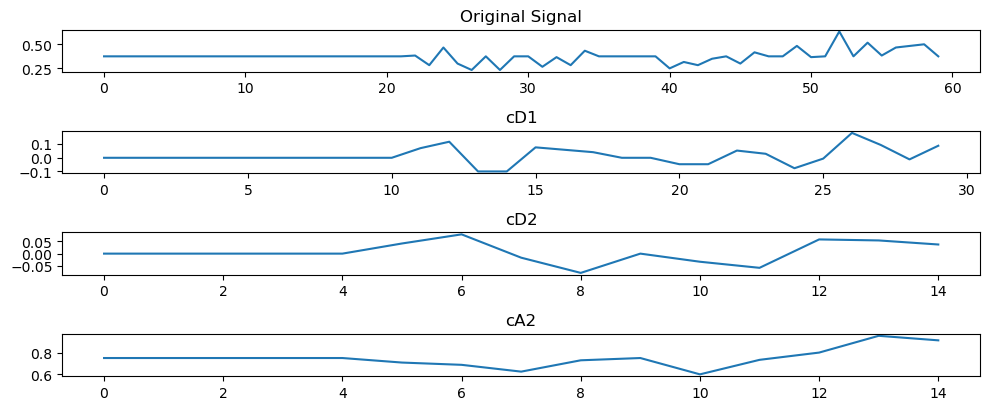

In [13]:
import pywt
import matplotlib.pyplot as plt

def dwt(data, wavelet='db1', level=2):
    """
    Apply Discrete Wavelet Transform (DWT) to the data.
    """
    coeffs = pywt.wavedec(data, wavelet, level=level)
    return coeffs

def plot_dwt_comparison(original, D1, D2, A2):
    """
    Plot the comparison between the original signal and the decomposed signal.
    """
    plt.figure(figsize=(10, 6))
    plt.subplot(6, 1, 1)
    plt.plot(original)
    plt.title('Original Signal')
    plt.subplot(6, 1, 2)
    plt.plot(D1)
    plt.title('cD1')
    plt.tight_layout()
    plt.subplot(6, 1, 3)
    plt.plot(D2)
    plt.title('cD2')
    plt.tight_layout()
    plt.subplot(6, 1, 4)
    plt.plot(A2)
    plt.title('cA2')
    plt.tight_layout()



# Exemplo de uso
original_signal = train_patients[:,0]  # Substitua pelo seu sinal de treinamento
level = 2 # Nível de decomposição desejado

# Aplica a DWT no sinal original
coeffs = dwt(original_signal, wavelet='db1', level=level)
cA2, cD2, cD1  = coeffs

# Reconstrói o sinal decomposto mantendo o mesmo número de elementos
reconstructed_signal = pywt.waverec(coeffs, wavelet='db1')

# Plota a comparação entre o sinal original e o sinal reconstruído
plot_dwt_comparison(original_signal, cD1, cD2, cA2)


# Modelo 1 - Input de serie e tendencia

In [224]:
def train_model(data, input_size, pred_horizon):

    # Filtragem
    data_filter = filtragem(data)

    # Derivada
    data_dev = derivada(data)

    # PARAMS
    activationfcn = 'sigmoid'
    activationfcn1 = 'linear'
    optimizerfcn = 'adam'
    lossfcn = 'mse'
    n_features = 1
    units = 4
    units1 = 1

    # input layer
    inputs = Input(shape=((input_size*2, n_features)))
    inputs = Flatten()(inputs)

    # passar o input para a hidden layer - parte nao linear
    dense = Dense(units=4, activation='sigmoid')
    hidden = Flatten()(dense(inputs))

    # obter o 1 output (o da camada de input) e juntar ao 2 output (o primeiro output esta a saltar a hidden layer) - parte linear
    jump = Concatenate(axis=1)([inputs, hidden])
    outputs = Dense(units=1, activation='linear')(jump)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=optimizerfcn, loss=lossfcn)

    for i in range(0, np.size(data_filter, 1)):

        X, y = data_prep(data_filter[:, i], input_size, pred_horizon, True)
        X_dev, y_dev = data_prep(calcular_gradiente_manual(data_filter[:, i]), input_size, pred_horizon, True)

        X_concat = np.concatenate((X, X_dev), axis=1)

        if i == 0:
            X_train = X_concat
            y_train = y
        else:
            X_train = np.concatenate((X_train, X_concat), axis=0)
            y_train = np.concatenate((y_train, y), axis=0)

    print(X_train.shape)
    print(y_train.shape)
    if X_train.size != 0 and y_train.size != 0:
        # reshape de [padroes, n] para [padroes, n, n_features]
        #X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
        
        #X_train = X_train.reshape((X_train.shape[0], X_train.shape[1]))
        #X_train = np.expand_dims(X_train, axis=-1)

        model.fit(X_train, y_train, epochs=300, verbose=0)

    # Exibindo o score do modelo treinado
    score = model.evaluate(X_train, y_train, verbose=0)
    print('Score do modelo:', score)


    model_path = 'models/' + str(input_size) + '_' + str(pred_horizon) 
    model.save(model_path)
    print("Model --> ", model_path)

    backend.clear_session()

In [225]:
with tf.device('/cpu:0'):
    for input_size in n:
        for pred_horizon in pred_horizons:
            train_model(train_patients ,input_size, pred_horizon)

(1568, 8)
(1568,)


Score do modelo: 0.00764184445142746
Model -->  models/4_1
(1512, 8)
(1512,)


Score do modelo: 0.008527210913598537
Model -->  models/4_3
(1456, 8)
(1456,)


Score do modelo: 0.008869185112416744
Model -->  models/4_5
(1428, 8)
(1428,)


Score do modelo: 0.009159711189568043
Model -->  models/4_6
(1400, 8)
(1400,)


Score do modelo: 0.009560244157910347
Model -->  models/4_7
(1512, 12)
(1512,)


Score do modelo: 0.007529872935265303
Model -->  models/6_1
(1456, 12)
(1456,)


Score do modelo: 0.008182032033801079
Model -->  models/6_3
(1400, 12)
(1400,)


Score do modelo: 0.008634650148451328
Model -->  models/6_5
(1372, 12)
(1372,)


Score do modelo: 0.009184101596474648
Model -->  models/6_6
(1344, 12)
(1344,)


Score do modelo: 0.009819780476391315
Model -->  models/6_7
(1456, 16)
(1456,)


Score do modelo: 0.007544119376689196
Model -->  models/8_1
(1400, 16)
(1400,)


Score do modelo: 0.008747322484850883
Model -->  models/8_3
(1344, 16)
(1344,)


Score do modelo: 0.008693458512425423
Model -->  models/8_5
(1316, 16)
(1316,)


Score do modelo: 0.00912251602858305
Model -->  models/8_6
(1288, 16)
(1288,)


Score do modelo: 0.009373174980282784
Model -->  models/8_7
(1400, 20)
(1400,)


Score do modelo: 0.0077416542917490005
Model -->  models/10_1
(1344, 20)
(1344,)


Score do modelo: 0.008351907134056091
Model -->  models/10_3
(1288, 20)
(1288,)


Score do modelo: 0.008649214170873165
Model -->  models/10_5
(1260, 20)
(1260,)


Score do modelo: 0.009019446559250355
Model -->  models/10_6
(1232, 20)
(1232,)


Score do modelo: 0.009564739651978016
Model -->  models/10_7


## Test

In [226]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow import keras

def evaluate_model(model, X_test, y_test):
    """
    Evaluate the model on test data and return the evaluation metrics.
    """
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    corr = np.corrcoef(y_test.squeeze(), y_pred.squeeze())[0, 1]
    return mae, mse, corr

from scipy import signal
def ccf_values(series1, series2):
    p = series1
    q = series2
    p = (p - np.mean(p)) / (np.std(p) * len(p))
    q = (q - np.mean(q)) / (np.std(q))  
    c = np.correlate(p, q, 'full')
    return c

def ccf_plot(path, i, lags, ccf):
    fig, ax =plt.subplots(figsize=(9, 6))
    ax.plot(lags, ccf)
    ax.axvline(x = 0, color = 'black', lw = 1)
    ax.axhline(y = 0, color = 'black', lw = 1)
    ax.axhline(y = np.max(ccf), color = 'blue', lw = 1, linestyle='--', label = 'highest +/- correlation')
    ax.axhline(y = np.min(ccf), color = 'blue', lw = 1, linestyle='--')
    ax.set(ylim = [-1, 1])
    ax.set_title('Cross Correlation', weight='bold', fontsize = 15)
    ax.set_ylabel('Correlation Coefficients', weight='bold', 
    fontsize = 12)
    ax.set_xlabel('Time Lags', weight='bold', fontsize = 12)
    plt.legend()
    plt.savefig(os.path.join(path, f'paciente_{i}_correlation.png'))
    plt.close()

def test_model(data, input_size, pred_horizon):
    """
    Test the trained model on a group of test patients and save the evaluation metrics and plots.
    """
    # Load the trained model
    model_path = 'models/' + str(input_size) + '_' + str(pred_horizon)
    model = keras.models.load_model(model_path)

    # Create directories to save the plots and evaluation results
    plots_path = 'plots/' + str(input_size) + '_' + str(pred_horizon)
    os.makedirs(plots_path, exist_ok=True)
    results_path = 'results/' + str(input_size) + '_' + str(pred_horizon)
    os.makedirs(results_path, exist_ok=True)

    for i in range(0, np.size(data, 1)):
        # Filter the data and prepare the test inputs and targets
        data_filter = filtragem(data[:, i])
        X_test, y_test = data_prep(data_filter, input_size, pred_horizon, True)
        X_test_dev, _ = data_prep(calcular_gradiente_manual(data_filter), input_size, pred_horizon, True)

        X_test_concat = np.concatenate((X_test, X_test_dev), axis=1)
        X_test_concat = X_test_concat.reshape((X_test_concat.shape[0], X_test_concat.shape[1], 1))

        # Make predictions
        y_pred = model.predict(X_test_concat)

        # Plot the data and predictions
        plt.plot(data[:, i], label='Original Data')
        plt.plot(data_filter, label='Filtered Data')
        plt.plot(np.arange(input_size+pred_horizon-1, len(data_filter)), y_test.squeeze(), label='True Values')
        plt.plot(np.arange(input_size+pred_horizon-1, len(data_filter)), y_pred.squeeze(), label='Predictions')
        plt.legend()
        plt.savefig(os.path.join(plots_path, f'paciente_{i}.png'))
        plt.close()

        # Compute Cross-correlation
        # corr_values = signal.correlate(y_pred.squeeze(), y_test.squeeze(), mode='full')
        # corr_values = corr_values / np.concatenate((np.arange(1, len(y_pred)+1), np.arange(len(y_pred)-1, 0, -1)))
        # #print(corr_values)
        # plt.plot(np.arange(-len(y_pred)+1, len(y_pred)), corr_values)
        # plt.xlim((-15, 15))
        # plt.show()

        # # Compute cross-correlation
        # x = data_filter[input_size-1:-pred_horizon]
        # y = y_pred.squeeze()
        # ccf_ielts = ccf_values(x, y)
        # lags = signal.correlation_lags(len(x), len(y))
        # ccf_plot(plots_path, i, lags, ccf_ielts)
        
        
        # Evaluate the model and save the results
        mae, mse, corr = evaluate_model(model, X_test_concat, y_test)
        with open(os.path.join(results_path, f'paciente_{i}.txt'), 'w') as f:
            f.write(f'MAE: {mae:.4f}\nMSE: {mse:.4f}\nCORR: {corr:.4f}')

    backend.clear_session()


In [227]:
for input_size in n:
    for pred_horizon in [1, 3, 5, 6, 7]:
        test_model(test_patients ,input_size, pred_horizon)

2/2 [==============================] - 0s 37ms/step


2023-07-18 22:35:11.903153: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 4ms/step


### AVG

In [124]:
import os

for horizon in pred_horizons:
    for input_size in n:
        results_dir = f"results/{input_size}_{horizon}"

        # Criar dicionário para armazenar os resultados
        results_dict = {}

        # Percorrer todos os arquivos txt na pasta de resultados
        for file_name in os.listdir(results_dir):
            if file_name.endswith(".txt"):
                # Obter o nome do paciente a partir do nome do arquivo
                patient_name = file_name.split("_")[0]
                file_path = os.path.join(results_dir, file_name)
                with open(file_path, "r") as f:
                    # Ler os resultados do arquivo
                    results = [float(line.split(":")[1].strip()) for line in f.readlines()]
                # Adicionar os resultados ao dicionário
                if patient_name in results_dict:
                    results_dict[patient_name].append(results)
                else:
                    results_dict[patient_name] = [results]

        # Calcular a média dos resultados para cada paciente
        for patient_name, results_list in results_dict.items():
            # Calcular a média de cada métrica
            mae_list = [results[0] for results in results_list]
            mae_avg = sum(mae_list) / len(mae_list)
            mse_list = [results[1] for results in results_list]
            mse_avg = sum(mse_list) / len(mse_list)
            corr_list = [results[2] for results in results_list]
            corr_avg = sum(corr_list) / len(corr_list)
            # Salvar os resultados médios em um novo arquivo txt
            output_file_path = f"results/{input_size}_{horizon}/{patient_name}_avg.txt"
            with open(output_file_path, "w") as f:
                f.write(f"MAE: {mae_avg:.4f}\n")
                f.write(f"MSE: {mse_avg:.4f}\n")
                f.write(f"CORR: {corr_avg:.4f}\n")


In [129]:
import os
import csv

def generate_model_info_csv():
    result_path = 'results'
    output_csv_path = 'model_info.csv'

    # Get the list of folders in the results directory
    folders = os.listdir(result_path)

    # Initialize the data lists
    model_info = []

    # Iterate over the folders
    for folder in folders:
        folder_path = os.path.join(result_path, folder)
        if os.path.isdir(folder_path):
            # Extract input size and prediction horizon from the folder name
            input_size, pred_horizon = map(int, folder.split('_'))

            # Read the paciente_avg.txt file
            file_path = os.path.join(folder_path, 'paciente_avg.txt')
            with open(file_path, 'r') as f:
                lines = f.readlines()

            # Parse the metrics from the file
            mae = float(lines[0].split(':')[1].strip())
            mse = float(lines[1].split(':')[1].strip())
            corr = float(lines[2].split(':')[1].strip())

            # Append the data to the list
            model_info.append((input_size, pred_horizon, mae, mse, corr))

    # Sort the model info list by input_size and pred_horizon
    sorted_model_info = sorted(model_info, key=lambda x: (x[0], x[1]))

    # Write the data to a CSV file
    with open(output_csv_path, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(['Input Size', 'Prediction Horizon', 'MAE', 'MSE', 'CORR'])
        writer.writerows(sorted_model_info)

    print(f"Model information has been saved to '{output_csv_path}'.")

generate_model_info_csv()


Model information has been saved to 'model_info.csv'.


# Classification

In [113]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

def create_classification_model(input_size):
    model = Sequential()
    model.add(LSTM(32, input_shape=(input_size, 1)))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

def data_prep_class(data, gradiente, input_size, pred_horizon):
    X, y = [], []
    for i in range(len(data)):
        end_ix = i + input_size  # encontrar o final do padrão
        output_ix = end_ix + pred_horizon - 1 # output
        if output_ix > len(data)-1:
            break
        if np.isnan(np.sum(data[i:end_ix])) or np.isnan(data[output_ix]):
            continue

        # input e output do padrão
        seq_x, seq_y = data[i:end_ix], data[output_ix]
        
        # Verificar se o gradiente é positivo e o momento está acima de 140
        if gradiente[end_ix-1] > 0 and seq_y > 140:
            y.append(1)  # Classificação positiva
        else:
            y.append(0)  # Classificação negativa
        
        X.append(seq_x)
        
    return np.array(X), np.array(y)




def train_model_class(data, input_size, pred_horizon):
    for i in range(0, np.size(data, 1)):
        gradiente = derivada(data[:, i])
        X, y = data_prep_class(data[:, i], gradiente, input_size, pred_horizon)

        if len(X) < 2:
            raise ValueError("Training data contains insufficient samples to perform validation split.")

        model = create_classification_model(input_size)

        early_stopping = EarlyStopping(monitor='val_loss', patience=5)

        history = model.fit(X, y, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

        model_path = 'models_class/' + str(input_size) + '_' + str(pred_horizon) 
        model.save(model_path)
        print("Model --> ", model_path)

        return model, history


def test_model_class(model, data, input_size, pred_horizon, threshold=140):
    plots_path = 'plots_class/' + str(input_size) + '_' + str(pred_horizon)
    os.makedirs(plots_path, exist_ok=True)
    
    results_path = os.path.join(plots_path, 'accuracy.txt')
    with open(results_path, 'w') as file:
        for i in range(0, np.size(data, 1)):
            gradient = derivada(data[:, i])
            X, y = data_prep_class(gradient, data[:, i], input_size, pred_horizon)
            y_pred = model.predict(X)
            y_pred = np.round(y_pred)

            accuracy = accuracy_score(y, y_pred)
            file.write(f'Patient {i}: Accuracy = {accuracy}\n')

            plt.figure()
            plt.plot(data[:, i], label='Original Series')
            plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
            plt.fill_between(range(len(data[:, i])), 0, 200, where=(data[:, i] > threshold), color='red', alpha=0.3, label='Risk Zone')
            plt.legend()
            plt.savefig(os.path.join(plots_path, f'paciente_{i}.png'))
            plt.close()



In [134]:
with tf.device('/cpu:0'):
    for input_size in [10]:
        for pred_horizon in [1,3,7]:
            model, history = train_model_class(train_patients, input_size, pred_horizon)

Epoch 1/50
2/2 [==============================] - 3s 735ms/step - loss: 0.8393 - accuracy: 0.0000e+00 - val_loss: 0.7859 - val_accuracy: 0.0000e+00
Epoch 2/50
2/2 [==============================] - 0s 29ms/step - loss: 0.7849 - accuracy: 0.0000e+00 - val_loss: 0.7343 - val_accuracy: 0.0000e+00
Epoch 3/50
2/2 [==============================] - 0s 28ms/step - loss: 0.7337 - accuracy: 0.0000e+00 - val_loss: 0.6866 - val_accuracy: 1.0000
Epoch 4/50
2/2 [==============================] - 0s 28ms/step - loss: 0.6862 - accuracy: 0.8750 - val_loss: 0.6426 - val_accuracy: 1.0000
Epoch 5/50
2/2 [==============================] - 0s 27ms/step - loss: 0.6421 - accuracy: 1.0000 - val_loss: 0.5999 - val_accuracy: 1.0000
Epoch 6/50
2/2 [==============================] - 0s 28ms/step - loss: 0.5962 - accuracy: 1.0000 - val_loss: 0.5535 - val_accuracy: 1.0000
Epoch 7/50
2/2 [==============================] - 0s 27ms/step - loss: 0.5497 - accuracy: 1.0000 - val_loss: 0.5092 - val_accuracy: 1.0000
Epoch 

Model -->  models_class/10_1
Epoch 1/50
2/2 [==============================] - 2s 411ms/step - loss: 1.2810 - accuracy: 0.0000e+00 - val_loss: 1.2130 - val_accuracy: 0.0000e+00
Epoch 2/50
2/2 [==============================] - 0s 28ms/step - loss: 1.2023 - accuracy: 0.0000e+00 - val_loss: 1.1417 - val_accuracy: 0.0000e+00
Epoch 3/50
2/2 [==============================] - 0s 29ms/step - loss: 1.1315 - accuracy: 0.0000e+00 - val_loss: 1.0745 - val_accuracy: 0.0000e+00
Epoch 4/50
2/2 [==============================] - 0s 30ms/step - loss: 1.0646 - accuracy: 0.0000e+00 - val_loss: 1.0102 - val_accuracy: 0.0000e+00
Epoch 5/50
2/2 [==============================] - 0s 29ms/step - loss: 1.0009 - accuracy: 0.0000e+00 - val_loss: 0.9486 - val_accuracy: 0.0000e+00
Epoch 6/50
2/2 [==============================] - 0s 28ms/step - loss: 0.9400 - accuracy: 0.0000e+00 - val_loss: 0.8898 - val_accuracy: 0.0000e+00
Epoch 7/50
2/2 [==============================] - 0s 27ms/step - loss: 0.8821 - accuracy

Model -->  models_class/10_3
Epoch 1/50
2/2 [==============================] - 3s 440ms/step - loss: 0.5904 - accuracy: 1.0000 - val_loss: 0.5609 - val_accuracy: 1.0000
Epoch 2/50
2/2 [==============================] - 0s 28ms/step - loss: 0.5599 - accuracy: 1.0000 - val_loss: 0.5348 - val_accuracy: 1.0000
Epoch 3/50
2/2 [==============================] - 0s 31ms/step - loss: 0.5338 - accuracy: 1.0000 - val_loss: 0.5095 - val_accuracy: 1.0000
Epoch 4/50
2/2 [==============================] - 0s 29ms/step - loss: 0.5084 - accuracy: 1.0000 - val_loss: 0.4859 - val_accuracy: 1.0000
Epoch 5/50
2/2 [==============================] - 0s 27ms/step - loss: 0.4848 - accuracy: 1.0000 - val_loss: 0.4643 - val_accuracy: 1.0000
Epoch 6/50
2/2 [==============================] - 0s 27ms/step - loss: 0.4632 - accuracy: 1.0000 - val_loss: 0.4435 - val_accuracy: 1.0000
Epoch 7/50
2/2 [==============================] - 0s 27ms/step - loss: 0.4424 - accuracy: 1.0000 - val_loss: 0.4233 - val_accuracy: 1.00

Model -->  models_class/10_7


In [135]:
with tf.device('/cpu:0'):
    for input_size in [10]:
        for pred_horizon in [1,3,7]:
                # Load the trained model
            model_path = 'models_class/' + str(input_size) + '_' + str(pred_horizon)
            model = keras.models.load_model(model_path)
            test_model_class(model, test_patients, input_size, pred_horizon)


2/2 [==============================] - 0s 2ms/step


## Sistema de classificação

In [144]:
def test_model_classification(data, input_size, pred_horizon):
    """
    Test the trained model on a group of test patients and save the evaluation metrics and plots.
    """
    # Load the trained model
    model_path = 'models/' + str(input_size) + '_' + str(pred_horizon)
    model = keras.models.load_model(model_path)

    # Create directories to save the plots and evaluation results
    plots_path = 'plots/' + str(input_size) + '_' + str(pred_horizon)
    os.makedirs(plots_path, exist_ok=True)
    results_path = 'results/' + str(input_size) + '_' + str(pred_horizon)
    os.makedirs(results_path, exist_ok=True)

    for i in range(0, np.size(data, 1)):
        # Filter the data and prepare the test inputs and targets
        data_filter = filtragem(data[:, i])
        X_test, y_test = data_prep(data_filter, input_size, pred_horizon, True)
        X_test_dev, _ = data_prep(derivada(data_filter), input_size, pred_horizon, True)

        X_test_concat = np.concatenate((X_test, X_test_dev), axis=1)
        X_test_concat = X_test_concat.reshape((X_test_concat.shape[0], X_test_concat.shape[1], 1))

        # Make predictions
        y_pred = model.predict(X_test_concat)

        # Calculate hypertension values above 135
        hypertension_threshold = 135
        true_hypertension = (y_test.squeeze() > hypertension_threshold).astype(int)
        predicted_hypertension = (y_pred.squeeze() > hypertension_threshold).astype(int)

        # Assess risk based on the percentage of values above the threshold
        threshold_percentage = 0.1
        true_hypertension_percentage = np.mean(predicted_hypertension)
        risk_assessment = true_hypertension_percentage > threshold_percentage

        # Plot the comparison between predicted and true hypertension
        plt.plot(np.arange(input_size+pred_horizon-1, len(data_filter)), y_test, label='True Hypertension')
        plt.plot(np.arange(input_size+pred_horizon-1, len(data_filter)), y_pred, label='Predicted Hypertension')
        plt.axhline(y=hypertension_threshold, color='r', linestyle='--', label=f'Threshold {hypertension_threshold}')
        plt.legend()

        # Add risk assessment to the plot
        assessment_text = 'At Risk' if risk_assessment else 'Not at Risk'
        plt.text(0.05, 0.9, assessment_text, transform=plt.gca().transAxes, fontsize=12)

        plt.savefig(os.path.join(plots_path, f'comparison_paciente_{i}.png'))
        plt.close()


In [145]:
for input_size in n:
    for pred_horizon in pred_horizons:
        test_model_classification(test_patients, input_size, pred_horizon)

2/2 [==============================] - 0s 4ms/step


In [170]:
import os
import csv

def calculate_average_accuracy():
    folders = [folder for folder in os.listdir('plots_class') if os.path.isdir(os.path.join('plots_class', folder))]

    results = []
    for folder in folders:
        folder_path = os.path.join('plots_class', folder)
        accuracy_files = [file for file in os.listdir(folder_path) if file.endswith('.txt')]

        accuracies = []
        for file in accuracy_files:
            file_path = os.path.join(folder_path, file)
            with open(file_path, 'r') as f:
                lines = f.readlines()
                for line in lines:
                    if line.startswith('Patient 5:'):
                        accuracy = float(line.split('=')[1].strip())
                        accuracies.append(accuracy)
                        break

        if len(accuracies) > 0:
            average_accuracy = sum(accuracies) / len(accuracies)
        else:
            average_accuracy = 0

        results.append((folder, average_accuracy))

    csv_path = 'average_accuracies.csv'
    with open(csv_path, 'w', newline='') as csv_file:
        writer = csv.writer(csv_file)
        writer.writerow(['Model', 'Average Accuracy'])
        writer.writerows(results)

    print("Average accuracies have been calculated and saved to 'average_accuracies.csv'.")


calculate_average_accuracy()

Average accuracies have been calculated and saved to 'average_accuracies.csv'.


## New Classification [5, 6, 7]

In [24]:
import numpy as np
from sklearn.metrics import f1_score, precision_score, recall_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
import csv

# Função para criar o modelo de classificação
def create_classification_model(input_size):
    model = keras.Sequential([
        Dense(64, activation='relu', input_shape=(input_size,)),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Função para preparar os dados de treinamento e teste
def data_prep_class(data, input_size, pred_horizons):
    X, y = [], []
    for patient_data in data:
        for i in range(input_size, len(patient_data) - max(pred_horizons) + 1):
            subset = patient_data[i - input_size:i + max(pred_horizons)]
            if len(subset) != input_size + max(pred_horizons):
                continue
            seq_x = subset[:input_size]
            seq_y = [1 if val > 140 else 0 for val in subset[-np.array(pred_horizons)]]
            X.append(seq_x)
            y.append(1 if sum(seq_y) >= 2 else 0)
    return np.array(X), np.array(y)

# Função para treinar o modelo de classificação
def train_model_class(data, input_size, pred_horizons):
    X, y = data_prep_class(data, input_size, pred_horizons)

    model = create_classification_model(input_size)

    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

    history = model.fit(X, y, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

    return model, history

# Função para avaliar o modelo de classificação e gerar o plot de cada paciente
def test_model_class(model, data, input_size, pred_horizons, threshold=140):
    plots_path = 'plots_class_3days'
    os.makedirs(plots_path, exist_ok=True)

    metrics = {'accuracy': [], 'precision': [], 'recall': [], 'f1_score': [], 'patient_risk': []}

    for i, patient_data in enumerate(data):
        X, y = data_prep_class([patient_data], input_size, pred_horizons)
        y_pred = model.predict(X)
        y_pred = np.round(y_pred)

        plt.figure()
        plt.plot(patient_data, label='Original Series')
        plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
        plt.fill_between(range(len(patient_data)), 0, 200, where=(patient_data > threshold), color='red', alpha=0.3, label='Risk Zone')
        plt.legend()

        patient_risk = 'At Risk' if sum(y_pred.flatten()) >= 2 else 'Not at Risk'
        plt.text(0.05, 0.95, f'Patient {i+1}: {patient_risk}', transform=plt.gca().transAxes, va='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
        
        plt.savefig(os.path.join(plots_path, f'patient_{i+1}.png'))
        plt.close()

        accuracy = accuracy_score(y, y_pred)
        precision = precision_score(y, y_pred)
        recall = recall_score(y, y_pred)
        f1 = f1_score(y, y_pred)

        metrics['accuracy'].append(accuracy)
        metrics['precision'].append(precision)
        metrics['recall'].append(recall)
        metrics['f1_score'].append(f1)
        metrics['patient_risk'].append(patient_risk)

    metrics_path = 'classification_metrics.csv'
    with open(metrics_path, 'w', newline='') as csv_file:
        writer = csv.writer(csv_file)
        writer.writerow(['Patient', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'Patient Risk'])
        for i in range(len(data)):
            writer.writerow([i+1, metrics['accuracy'][i], metrics['precision'][i], metrics['recall'][i], metrics['f1_score'][i], metrics['patient_risk'][i]])

    print("Classification metrics have been calculated and saved to 'classification_metrics.csv'.")




In [28]:
# Exemplo de uso:
input_size = 4
pred_horizons = [5, 6, 7]

# Treinamento do modelo
with tf.device('/cpu:0'):
    model, history = train_model_class(train_patients, input_size, pred_horizons)

# Teste do modelo e métricas de avaliação
test_model_class(model, test_patients, input_size, pred_horizons)

Epoch 1/50
27/27 [==============================] - 1s 17ms/step - loss: 0.7868 - accuracy: 0.9132 - val_loss: 0.1760 - val_accuracy: 0.9769
Epoch 2/50
27/27 [==============================] - 0s 2ms/step - loss: 0.2430 - accuracy: 0.9491 - val_loss: 0.0791 - val_accuracy: 0.9769
Epoch 3/50
27/27 [==============================] - 0s 2ms/step - loss: 0.2178 - accuracy: 0.9317 - val_loss: 0.1034 - val_accuracy: 0.9769
Epoch 4/50
27/27 [==============================] - 0s 2ms/step - loss: 0.2283 - accuracy: 0.9340 - val_loss: 0.1579 - val_accuracy: 0.9769
Epoch 5/50
27/27 [==============================] - 0s 2ms/step - loss: 0.1753 - accuracy: 0.9375 - val_loss: 0.1708 - val_accuracy: 0.9398
Epoch 6/50
27/27 [==============================] - 0s 3ms/step - loss: 0.1424 - accuracy: 0.9479 - val_loss: 0.0756 - val_accuracy: 0.9769
Epoch 7/50
27/27 [==============================] - 0s 2ms/step - loss: 0.1756 - accuracy: 0.9375 - val_loss: 0.0704 - val_accuracy: 0.9769
Epoch 8/50
27/27 [=

/Users/rsaraiva/opt/anaconda3/envs/POWER/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rsaraiva/opt/anaconda3/envs/POWER/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rsaraiva/opt/anaconda3/envs/POWER/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/rsaraiva/opt/a

1/1 [==============================] - 0s 24ms/step


/Users/rsaraiva/opt/anaconda3/envs/POWER/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rsaraiva/opt/anaconda3/envs/POWER/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rsaraiva/opt/anaconda3/envs/POWER/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/rsaraiva/opt/a

1/1 [==============================] - 0s 24ms/step


/Users/rsaraiva/opt/anaconda3/envs/POWER/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rsaraiva/opt/anaconda3/envs/POWER/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rsaraiva/opt/anaconda3/envs/POWER/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/rsaraiva/opt/a

1/1 [==============================] - 0s 24ms/step


/Users/rsaraiva/opt/anaconda3/envs/POWER/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rsaraiva/opt/anaconda3/envs/POWER/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rsaraiva/opt/anaconda3/envs/POWER/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/rsaraiva/opt/a

1/1 [==============================] - 0s 23ms/step


/Users/rsaraiva/opt/anaconda3/envs/POWER/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rsaraiva/opt/anaconda3/envs/POWER/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rsaraiva/opt/anaconda3/envs/POWER/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/rsaraiva/opt/a

1/1 [==============================] - 0s 25ms/step


/Users/rsaraiva/opt/anaconda3/envs/POWER/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rsaraiva/opt/anaconda3/envs/POWER/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rsaraiva/opt/anaconda3/envs/POWER/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/rsaraiva/opt/a

1/1 [==============================] - 0s 22ms/step


/Users/rsaraiva/opt/anaconda3/envs/POWER/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rsaraiva/opt/anaconda3/envs/POWER/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rsaraiva/opt/anaconda3/envs/POWER/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/rsaraiva/opt/a

1/1 [==============================] - 0s 24ms/step


/Users/rsaraiva/opt/anaconda3/envs/POWER/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rsaraiva/opt/anaconda3/envs/POWER/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rsaraiva/opt/anaconda3/envs/POWER/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/rsaraiva/opt/a

1/1 [==============================] - 0s 22ms/step


/Users/rsaraiva/opt/anaconda3/envs/POWER/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rsaraiva/opt/anaconda3/envs/POWER/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rsaraiva/opt/anaconda3/envs/POWER/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/rsaraiva/opt/a

1/1 [==============================] - 0s 25ms/step


/Users/rsaraiva/opt/anaconda3/envs/POWER/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rsaraiva/opt/anaconda3/envs/POWER/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rsaraiva/opt/anaconda3/envs/POWER/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/rsaraiva/opt/a

1/1 [==============================] - 0s 25ms/step


/Users/rsaraiva/opt/anaconda3/envs/POWER/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rsaraiva/opt/anaconda3/envs/POWER/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rsaraiva/opt/anaconda3/envs/POWER/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/rsaraiva/opt/a

1/1 [==============================] - 0s 26ms/step


/Users/rsaraiva/opt/anaconda3/envs/POWER/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rsaraiva/opt/anaconda3/envs/POWER/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rsaraiva/opt/anaconda3/envs/POWER/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/rsaraiva/opt/a

1/1 [==============================] - 0s 24ms/step


/Users/rsaraiva/opt/anaconda3/envs/POWER/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rsaraiva/opt/anaconda3/envs/POWER/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rsaraiva/opt/anaconda3/envs/POWER/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/rsaraiva/opt/a

1/1 [==============================] - 0s 24ms/step


/Users/rsaraiva/opt/anaconda3/envs/POWER/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rsaraiva/opt/anaconda3/envs/POWER/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rsaraiva/opt/anaconda3/envs/POWER/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/rsaraiva/opt/a

1/1 [==============================] - 0s 22ms/step


/Users/rsaraiva/opt/anaconda3/envs/POWER/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rsaraiva/opt/anaconda3/envs/POWER/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rsaraiva/opt/anaconda3/envs/POWER/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/rsaraiva/opt/a

1/1 [==============================] - 0s 23ms/step


/Users/rsaraiva/opt/anaconda3/envs/POWER/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rsaraiva/opt/anaconda3/envs/POWER/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rsaraiva/opt/anaconda3/envs/POWER/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/rsaraiva/opt/a

1/1 [==============================] - 0s 24ms/step


/Users/rsaraiva/opt/anaconda3/envs/POWER/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rsaraiva/opt/anaconda3/envs/POWER/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rsaraiva/opt/anaconda3/envs/POWER/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/rsaraiva/opt/a

1/1 [==============================] - 0s 24ms/step


/Users/rsaraiva/opt/anaconda3/envs/POWER/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rsaraiva/opt/anaconda3/envs/POWER/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rsaraiva/opt/anaconda3/envs/POWER/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/rsaraiva/opt/a

1/1 [==============================] - 0s 23ms/step


/Users/rsaraiva/opt/anaconda3/envs/POWER/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rsaraiva/opt/anaconda3/envs/POWER/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rsaraiva/opt/anaconda3/envs/POWER/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/rsaraiva/opt/a

1/1 [==============================] - 0s 26ms/step


/Users/rsaraiva/opt/anaconda3/envs/POWER/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rsaraiva/opt/anaconda3/envs/POWER/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rsaraiva/opt/anaconda3/envs/POWER/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/rsaraiva/opt/a

1/1 [==============================] - 0s 25ms/step


/Users/rsaraiva/opt/anaconda3/envs/POWER/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rsaraiva/opt/anaconda3/envs/POWER/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rsaraiva/opt/anaconda3/envs/POWER/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/rsaraiva/opt/a

1/1 [==============================] - 0s 24ms/step


/Users/rsaraiva/opt/anaconda3/envs/POWER/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rsaraiva/opt/anaconda3/envs/POWER/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rsaraiva/opt/anaconda3/envs/POWER/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/rsaraiva/opt/a

1/1 [==============================] - 0s 23ms/step


/Users/rsaraiva/opt/anaconda3/envs/POWER/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rsaraiva/opt/anaconda3/envs/POWER/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rsaraiva/opt/anaconda3/envs/POWER/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/rsaraiva/opt/a

1/1 [==============================] - 0s 23ms/step


/Users/rsaraiva/opt/anaconda3/envs/POWER/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rsaraiva/opt/anaconda3/envs/POWER/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rsaraiva/opt/anaconda3/envs/POWER/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/rsaraiva/opt/a

1/1 [==============================] - 0s 23ms/step


/Users/rsaraiva/opt/anaconda3/envs/POWER/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rsaraiva/opt/anaconda3/envs/POWER/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rsaraiva/opt/anaconda3/envs/POWER/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/rsaraiva/opt/a

1/1 [==============================] - 0s 24ms/step


/Users/rsaraiva/opt/anaconda3/envs/POWER/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rsaraiva/opt/anaconda3/envs/POWER/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rsaraiva/opt/anaconda3/envs/POWER/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/rsaraiva/opt/a

1/1 [==============================] - 0s 24ms/step


/Users/rsaraiva/opt/anaconda3/envs/POWER/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rsaraiva/opt/anaconda3/envs/POWER/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rsaraiva/opt/anaconda3/envs/POWER/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/rsaraiva/opt/a

1/1 [==============================] - 0s 24ms/step


/Users/rsaraiva/opt/anaconda3/envs/POWER/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rsaraiva/opt/anaconda3/envs/POWER/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rsaraiva/opt/anaconda3/envs/POWER/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/rsaraiva/opt/a

1/1 [==============================] - 0s 24ms/step


/Users/rsaraiva/opt/anaconda3/envs/POWER/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rsaraiva/opt/anaconda3/envs/POWER/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rsaraiva/opt/anaconda3/envs/POWER/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/rsaraiva/opt/a

1/1 [==============================] - 0s 24ms/step
Classification metrics have been calculated and saved to 'classification_metrics.csv'.


/Users/rsaraiva/opt/anaconda3/envs/POWER/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rsaraiva/opt/anaconda3/envs/POWER/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rsaraiva/opt/anaconda3/envs/POWER/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/rsaraiva/opt/a

# Modelo 2 - Unicamente serie

In [16]:
def train_model_simple(data, input_size, pred_horizon):
    # Filtragem
    data_filter = filtragem(data)

    # PARAMS
    activationfcn = 'sigmoid'
    activationfcn1 = 'linear'
    optimizerfcn = 'adam'
    lossfcn = 'mse'
    n_features = 1
    units = 4
    units1 = 1

    # input layer
    inputs = Input(shape=((input_size, n_features)))
    inputs = Flatten()(inputs)

    # passar o input para a hidden layer - parte nao linear
    dense = Dense(units=4, activation='sigmoid')
    hidden = Flatten()(dense(inputs))

    # obter o 1 output (o da camada de input) e juntar ao 2 output (o primeiro output esta a saltar a hidden layer) - parte linear
    jump = Concatenate(axis=1)([inputs, hidden])
    outputs = Dense(units=1, activation='linear')(jump)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=optimizerfcn, loss=lossfcn)

    for i in range(0, np.size(data_filter, 1)):

        X, y = data_prep(data_filter[:, i], input_size, pred_horizon, True)

    print(X.shape)
    print(y.shape)
    if X.size != 0 and y.size != 0:
        # reshape de [padroes, n] para [padroes, n, n_features]
        #X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
        
        #X_train = X_train.reshape((X_train.shape[0], X_train.shape[1]))
        #X_train = np.expand_dims(X_train, axis=-1)

        model.fit(X, y, epochs=300, verbose=0)

    # Exibindo o score do modelo treinado
    score = model.evaluate(X, y, verbose=0)
    print('Score do modelo:', score)


    model_path = 'models_simple/' + str(input_size) + '_' + str(pred_horizon) 
    model.save(model_path)
    print("Model --> ", model_path)

    backend.clear_session()

In [17]:
with tf.device('/cpu:0'):
    for input_size in n:
        for pred_horizon in pred_horizons:
            train_model_simple(train_patients ,input_size, pred_horizon)

(56, 4)
(56,)
Score do modelo: 316.90875244140625
Model -->  models_simple/4_1
(54, 4)
(54,)
Score do modelo: 6972.21044921875
Model -->  models_simple/4_3
(52, 4)
(52,)
Score do modelo: 27.31956672668457
Model -->  models_simple/4_5
(51, 4)
(51,)
Score do modelo: 54.84141540527344
Model -->  models_simple/4_6
(50, 4)
(50,)
Score do modelo: 3317.62255859375
Model -->  models_simple/4_7
(54, 6)
(54,)
Score do modelo: 25.790664672851562
Model -->  models_simple/6_1
(52, 6)
(52,)
Score do modelo: 10257.07421875
Model -->  models_simple/6_3
(50, 6)
(50,)
Score do modelo: 50.442901611328125
Model -->  models_simple/6_5
(49, 6)
(49,)
Score do modelo: 45.509193420410156
Model -->  models_simple/6_6
(48, 6)
(48,)
Score do modelo: 49.543399810791016
Model -->  models_simple/6_7
(52, 8)
(52,)
Score do modelo: 60.554283142089844
Model -->  models_simple/8_1
(50, 8)
(50,)
Score do modelo: 52.794189453125
Model -->  models_simple/8_3
(48, 8)
(48,)
Score do modelo: 70.16014099121094
Model -->  model

## Test

In [18]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow import keras

def evaluate_model(model, X_test, y_test):
    """
    Evaluate the model on test data and return the evaluation metrics.
    """
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    corr = np.corrcoef(y_test.squeeze(), y_pred.squeeze())[0, 1]
    return mae, mse, corr

from scipy import signal
def ccf_values(series1, series2):
    p = series1
    q = series2
    p = (p - np.mean(p)) / (np.std(p) * len(p))
    q = (q - np.mean(q)) / (np.std(q))  
    c = np.correlate(p, q, 'full')
    return c

def ccf_plot(path, i, lags, ccf):
    fig, ax =plt.subplots(figsize=(9, 6))
    ax.plot(lags, ccf)
    ax.axvline(x = 0, color = 'black', lw = 1)
    ax.axhline(y = 0, color = 'black', lw = 1)
    ax.axhline(y = np.max(ccf), color = 'blue', lw = 1, linestyle='--', label = 'highest +/- correlation')
    ax.axhline(y = np.min(ccf), color = 'blue', lw = 1, linestyle='--')
    ax.set(ylim = [-1, 1])
    ax.set_title('Cross Correlation', weight='bold', fontsize = 15)
    ax.set_ylabel('Correlation Coefficients', weight='bold', 
    fontsize = 12)
    ax.set_xlabel('Time Lags', weight='bold', fontsize = 12)
    plt.legend()
    plt.savefig(os.path.join(path, f'paciente_{i}_correlation.png'))
    plt.close()

def test_model_simple(data, input_size, pred_horizon):
    """
    Test the trained model on a group of test patients and save the evaluation metrics and plots.
    """
    # Load the trained model
    model_path = 'models_simple/' + str(input_size) + '_' + str(pred_horizon)
    model = keras.models.load_model(model_path)

    # Create directories to save the plots and evaluation results
    plots_path = 'plots_simple/' + str(input_size) + '_' + str(pred_horizon)
    os.makedirs(plots_path, exist_ok=True)
    results_path = 'results_simple/' + str(input_size) + '_' + str(pred_horizon)
    os.makedirs(results_path, exist_ok=True)

    for i in range(0, np.size(data, 1)):
        # Filter the data and prepare the test inputs and targets
        data_filter = filtragem(data[:, i])
        X_test, y_test = data_prep(data_filter, input_size, pred_horizon, True)

        # Make predictions
        y_pred = model.predict(X_test)

        # Plot the data and predictions
        plt.plot(data[:, i], label='Original Data')
        plt.plot(data_filter, label='Filtered Data')
        plt.plot(np.arange(input_size+pred_horizon-1, len(data_filter)), y_test.squeeze(), label='True Values')
        plt.plot(np.arange(input_size+pred_horizon-1, len(data_filter)), y_pred.squeeze(), label='Predictions')
        plt.legend()
        plt.savefig(os.path.join(plots_path, f'paciente_{i}.png'))
        plt.close()

        # Compute Cross-correlation
        # corr_values = signal.correlate(y_pred.squeeze(), y_test.squeeze(), mode='full')
        # corr_values = corr_values / np.concatenate((np.arange(1, len(y_pred)+1), np.arange(len(y_pred)-1, 0, -1)))
        # #print(corr_values)
        # plt.plot(np.arange(-len(y_pred)+1, len(y_pred)), corr_values)
        # plt.xlim((-15, 15))
        # plt.show()

        # # Compute cross-correlation
        # x = data_filter[input_size-1:-pred_horizon]
        # y = y_pred.squeeze()
        # ccf_ielts = ccf_values(x, y)
        # lags = signal.correlation_lags(len(x), len(y))
        # ccf_plot(plots_path, i, lags, ccf_ielts)
        
        
        # Evaluate the model and save the results
        mae, mse, corr = evaluate_model(model, X_test, y_test)
        with open(os.path.join(results_path, f'paciente_{i}.txt'), 'w') as f:
            f.write(f'MAE: {mae:.4f}\nMSE: {mse:.4f}\nCORR: {corr:.4f}')

    backend.clear_session()


In [19]:
for input_size in n:
    for pred_horizon in [1, 3, 5, 6, 7]:
        test_model_simple(test_patients ,input_size, pred_horizon)

2/2 [==============================] - 0s 4ms/step


### AVG

In [20]:
import os

for horizon in pred_horizons:
    for input_size in n:
        results_dir = f"results_simple/{input_size}_{horizon}"

        # Criar dicionário para armazenar os resultados
        results_dict = {}

        # Percorrer todos os arquivos txt na pasta de resultados
        for file_name in os.listdir(results_dir):
            if file_name.endswith(".txt"):
                # Obter o nome do paciente a partir do nome do arquivo
                patient_name = file_name.split("_")[0]
                file_path = os.path.join(results_dir, file_name)
                with open(file_path, "r") as f:
                    # Ler os resultados do arquivo
                    results = [float(line.split(":")[1].strip()) for line in f.readlines()]
                # Adicionar os resultados ao dicionário
                if patient_name in results_dict:
                    results_dict[patient_name].append(results)
                else:
                    results_dict[patient_name] = [results]

        # Calcular a média dos resultados para cada paciente
        for patient_name, results_list in results_dict.items():
            # Calcular a média de cada métrica
            mae_list = [results[0] for results in results_list]
            mae_avg = sum(mae_list) / len(mae_list)
            mse_list = [results[1] for results in results_list]
            mse_avg = sum(mse_list) / len(mse_list)
            corr_list = [results[2] for results in results_list]
            corr_avg = sum(corr_list) / len(corr_list)
            # Salvar os resultados médios em um novo arquivo txt
            output_file_path = f"results_simple/{input_size}_{horizon}/{patient_name}_avg.txt"
            with open(output_file_path, "w") as f:
                f.write(f"MAE: {mae_avg:.4f}\n")
                f.write(f"MSE: {mse_avg:.4f}\n")
                f.write(f"CORR: {corr_avg:.4f}\n")


In [21]:
import os
import csv

def generate_model_info_csv():
    result_path = 'results_simple'
    output_csv_path = 'model_info_simple.csv'

    # Get the list of folders in the results directory
    folders = os.listdir(result_path)

    # Initialize the data lists
    model_info = []

    # Iterate over the folders
    for folder in folders:
        folder_path = os.path.join(result_path, folder)
        if os.path.isdir(folder_path):
            # Extract input size and prediction horizon from the folder name
            input_size, pred_horizon = map(int, folder.split('_'))

            # Read the paciente_avg.txt file
            file_path = os.path.join(folder_path, 'paciente_avg.txt')
            with open(file_path, 'r') as f:
                lines = f.readlines()

            # Parse the metrics from the file
            mae = float(lines[0].split(':')[1].strip())
            mse = float(lines[1].split(':')[1].strip())
            corr = float(lines[2].split(':')[1].strip())

            # Append the data to the list
            model_info.append((input_size, pred_horizon, mae, mse, corr))

    # Sort the model info list by input_size and pred_horizon
    sorted_model_info = sorted(model_info, key=lambda x: (x[0], x[1]))

    # Write the data to a CSV file
    with open(output_csv_path, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(['Input Size', 'Prediction Horizon', 'MAE', 'MSE', 'CORR'])
        writer.writerows(sorted_model_info)

    print(f"Model information has been saved to '{output_csv_path}'.")

generate_model_info_csv()

Model information has been saved to 'model_info_simple.csv'.


# Modelo 3 - Gradiente do input

In [294]:
def train_model_gradin(data, input_size, pred_horizon):

    # Filtragem
    data_filter = filtragem(data)

    # PARAMS
    activationfcn = 'sigmoid'
    activationfcn1 = 'linear'
    optimizerfcn = 'adam'
    lossfcn = 'mse'
    n_features = 1
    units = 4
    units1 = 1

    # input layer
    inputs = Input(shape=((input_size*2, n_features)))
    inputs = Flatten()(inputs)

    # passar o input para a hidden layer - parte nao linear
    dense = Dense(units=4, activation='sigmoid')
    hidden = Flatten()(dense(inputs))

    # obter o 1 output (o da camada de input) e juntar ao 2 output (o primeiro output esta a saltar a hidden layer) - parte linear
    jump = Concatenate(axis=1)([inputs, hidden])
    outputs = Dense(units=1, activation='linear')(jump)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=optimizerfcn, loss=lossfcn)

    for i in range(0, np.size(data_filter, 1)):

        X, y = data_prep(data_filter[:, i], input_size, pred_horizon, True)
        X_dev = derivada(X)  # Calcular a derivada do X
        X_concat = np.concatenate((X, X_dev), axis=1)

        if i == 0:
            X_train = X_concat
            y_train = y
        else:
            X_train = np.concatenate((X_train, X_concat), axis=0)
            y_train = np.concatenate((y_train, y), axis=0)

    if X_train.size != 0 and y_train.size != 0:
        # reshape de [padroes, n] para [padroes, n, n_features]
        #X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
        
        #X_train = X_train.reshape((X_train.shape[0], X_train.shape[1]))
        #X_train = np.expand_dims(X_train, axis=-1)

        model.fit(X_train, y_train, epochs=300, verbose=0)

    # Exibindo o score do modelo treinado
    score = model.evaluate(X_train, y_train, verbose=0)
    print('Score do modelo:', score)


    model_path = 'models_gradin/' + str(input_size) + '_' + str(pred_horizon) 
    model.save(model_path)
    print("Model --> ", model_path)

    backend.clear_session()

In [295]:
with tf.device('/cpu:0'):
    for input_size in n:
        for pred_horizon in pred_horizons:
            train_model_gradin(train_patients ,input_size, pred_horizon)

Score do modelo: 0.00020672411483246833
Model -->  models_gradin/4_1


Score do modelo: 0.008475759997963905
Model -->  models_gradin/4_3


Score do modelo: 0.008586066775023937
Model -->  models_gradin/4_5


Score do modelo: 0.009001507423818111
Model -->  models_gradin/4_6


Score do modelo: 0.009278607554733753
Model -->  models_gradin/4_7


Score do modelo: 0.00021652065333910286
Model -->  models_gradin/6_1


Score do modelo: 0.007969805039465427
Model -->  models_gradin/6_3


Score do modelo: 0.008632897399365902
Model -->  models_gradin/6_5


Score do modelo: 0.008756929077208042
Model -->  models_gradin/6_6
Score do modelo: 0.009294625371694565


Model -->  models_gradin/6_7


Score do modelo: 0.0003930928651243448
Model -->  models_gradin/8_1


Score do modelo: 0.00822452362626791
Model -->  models_gradin/8_3


Score do modelo: 0.00872668158262968
Model -->  models_gradin/8_5


Score do modelo: 0.008616635575890541
Model -->  models_gradin/8_6


Score do modelo: 0.00960622914135456
Model -->  models_gradin/8_7


Score do modelo: 0.0003121485351584852
Model -->  models_gradin/10_1


Score do modelo: 0.008240894414484501
Model -->  models_gradin/10_3


Score do modelo: 0.008959331549704075
Model -->  models_gradin/10_5


Score do modelo: 0.008883490227162838
Model -->  models_gradin/10_6


Score do modelo: 0.009336428716778755
Model -->  models_gradin/10_7


## Test

In [296]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow import keras

def evaluate_model(model, X_test, y_test):
    """
    Evaluate the model on test data and return the evaluation metrics.
    """
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    corr = np.corrcoef(y_test.squeeze(), y_pred.squeeze())[0, 1]
    return mae, mse, corr

from scipy import signal
def ccf_values(series1, series2):
    p = series1
    q = series2
    p = (p - np.mean(p)) / (np.std(p) * len(p))
    q = (q - np.mean(q)) / (np.std(q))  
    c = np.correlate(p, q, 'full')
    return c

def ccf_plot(path, i, lags, ccf):
    fig, ax =plt.subplots(figsize=(9, 6))
    ax.plot(lags, ccf)
    ax.axvline(x = 0, color = 'black', lw = 1)
    ax.axhline(y = 0, color = 'black', lw = 1)
    ax.axhline(y = np.max(ccf), color = 'blue', lw = 1, linestyle='--', label = 'highest +/- correlation')
    ax.axhline(y = np.min(ccf), color = 'blue', lw = 1, linestyle='--')
    ax.set(ylim = [-1, 1])
    ax.set_title('Cross Correlation', weight='bold', fontsize = 15)
    ax.set_ylabel('Correlation Coefficients', weight='bold', 
    fontsize = 12)
    ax.set_xlabel('Time Lags', weight='bold', fontsize = 12)
    plt.legend()
    plt.savefig(os.path.join(path, f'paciente_{i}_correlation.png'))
    plt.close()

def test_model_gradin(data, input_size, pred_horizon):
    """
    Test the trained model on a group of test patients and save the evaluation metrics and plots.
    """
    # Load the trained model
    model_path = 'models_gradin/' + str(input_size) + '_' + str(pred_horizon)
    model = keras.models.load_model(model_path)

    # Create directories to save the plots and evaluation results
    plots_path = 'plots_gradin/' + str(input_size) + '_' + str(pred_horizon)
    os.makedirs(plots_path, exist_ok=True)
    results_path = 'results_gradin/' + str(input_size) + '_' + str(pred_horizon)
    os.makedirs(results_path, exist_ok=True)

    for i in range(0, np.size(data, 1)):
        # Filter the data and prepare the test inputs and targets
        data_filter = filtragem(data[:, i])
        X_test, y_test = data_prep(data_filter, input_size, pred_horizon, True)
        X_test_dev = derivada(X_test)

        X_test_concat = np.concatenate((X_test, X_test_dev), axis=1)
        X_test_concat = X_test_concat.reshape((X_test_concat.shape[0], X_test_concat.shape[1], 1))

        # Make predictions
        y_pred = model.predict(X_test_concat)

        # Plot the data and predictions
        plt.plot(data[:, i], label='Original Data')
        plt.plot(data_filter, label='Filtered Data')
        plt.plot(np.arange(input_size+pred_horizon-1, len(data_filter)), y_test.squeeze(), label='True Values')
        plt.plot(np.arange(input_size+pred_horizon-1, len(data_filter)), y_pred.squeeze(), label='Predictions')
        plt.legend()
        plt.savefig(os.path.join(plots_path, f'paciente_{i}.png'))
        plt.close()

        # Compute Cross-correlation
        # corr_values = signal.correlate(y_pred.squeeze(), y_test.squeeze(), mode='full')
        # corr_values = corr_values / np.concatenate((np.arange(1, len(y_pred)+1), np.arange(len(y_pred)-1, 0, -1)))
        # #print(corr_values)
        # plt.plot(np.arange(-len(y_pred)+1, len(y_pred)), corr_values)
        # plt.xlim((-15, 15))
        # plt.show()

        # # Compute cross-correlation
        # x = data_filter[input_size-1:-pred_horizon]
        # y = y_pred.squeeze()
        # ccf_ielts = ccf_values(x, y)
        # lags = signal.correlation_lags(len(x), len(y))
        # ccf_plot(plots_path, i, lags, ccf_ielts)
        
        
        # Evaluate the model and save the results
        mae, mse, corr = evaluate_model(model, X_test_concat, y_test)
        with open(os.path.join(results_path, f'paciente_{i}.txt'), 'w') as f:
            f.write(f'MAE: {mae:.4f}\nMSE: {mse:.4f}\nCORR: {corr:.4f}')

    backend.clear_session()


In [297]:
for input_size in n:
    for pred_horizon in [1, 3, 5, 6, 7]:
        test_model_gradin(test_patients ,input_size, pred_horizon)

1/2 [==============>...............] - ETA: 0s

2023-07-19 00:08:49.312557: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 40ms/step


2023-07-19 00:08:52.816145: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 46ms/step


2023-07-19 00:08:56.348784: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 42ms/step


2023-07-19 00:08:59.367819: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 37ms/step


2023-07-19 00:09:02.341200: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 34ms/step


2023-07-19 00:09:05.304237: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 37ms/step


2023-07-19 00:09:08.430539: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 43ms/step


2023-07-19 00:09:11.976247: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 42ms/step


2023-07-19 00:09:14.926535: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 47ms/step


2023-07-19 00:09:17.980475: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 38ms/step


2023-07-19 00:09:21.031168: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 35ms/step


2023-07-19 00:09:24.108169: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 40ms/step


2023-07-19 00:09:27.602015: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 34ms/step


2023-07-19 00:09:30.727002: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 46ms/step


2023-07-19 00:09:33.829655: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 39ms/step


2023-07-19 00:09:36.841678: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 40ms/step


2023-07-19 00:09:39.947282: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 38ms/step


2023-07-19 00:09:42.981345: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 44ms/step


2023-07-19 00:09:45.893381: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 42ms/step


2023-07-19 00:09:49.412382: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 5ms/step


### AVG

In [298]:
import os

for horizon in pred_horizons:
    for input_size in n:
        results_dir = f"results_gradin/{input_size}_{horizon}"

        # Criar dicionário para armazenar os resultados
        results_dict = {}

        # Percorrer todos os arquivos txt na pasta de resultados
        for file_name in os.listdir(results_dir):
            if file_name.endswith(".txt"):
                # Obter o nome do paciente a partir do nome do arquivo
                patient_name = file_name.split("_")[0]
                file_path = os.path.join(results_dir, file_name)
                with open(file_path, "r") as f:
                    # Ler os resultados do arquivo
                    results = [float(line.split(":")[1].strip()) for line in f.readlines()]
                # Adicionar os resultados ao dicionário
                if patient_name in results_dict:
                    results_dict[patient_name].append(results)
                else:
                    results_dict[patient_name] = [results]

        # Calcular a média dos resultados para cada paciente
        for patient_name, results_list in results_dict.items():
            # Calcular a média de cada métrica
            mae_list = [results[0] for results in results_list]
            mae_avg = sum(mae_list) / len(mae_list)
            mse_list = [results[1] for results in results_list]
            mse_avg = sum(mse_list) / len(mse_list)
            corr_list = [results[2] for results in results_list]
            corr_avg = sum(corr_list) / len(corr_list)
            # Salvar os resultados médios em um novo arquivo txt
            output_file_path = f"results_gradin/{input_size}_{horizon}/{patient_name}_avg.txt"
            with open(output_file_path, "w") as f:
                f.write(f"MAE: {mae_avg:.4f}\n")
                f.write(f"MSE: {mse_avg:.4f}\n")
                f.write(f"CORR: {corr_avg:.4f}\n")


In [299]:
import os
import csv

def generate_model_info_csv():
    result_path = 'results_gradin'
    output_csv_path = 'model_info_gradin.csv'

    # Get the list of folders in the results directory
    folders = os.listdir(result_path)

    # Initialize the data lists
    model_info = []

    # Iterate over the folders
    for folder in folders:
        folder_path = os.path.join(result_path, folder)
        if os.path.isdir(folder_path):
            # Extract input size and prediction horizon from the folder name
            input_size, pred_horizon = map(int, folder.split('_'))

            # Read the paciente_avg.txt file
            file_path = os.path.join(folder_path, 'paciente_avg.txt')
            with open(file_path, 'r') as f:
                lines = f.readlines()

            # Parse the metrics from the file
            mae = float(lines[0].split(':')[1].strip())
            mse = float(lines[1].split(':')[1].strip())
            corr = float(lines[2].split(':')[1].strip())

            # Append the data to the list
            model_info.append((input_size, pred_horizon, mae, mse, corr))

    # Sort the model info list by input_size and pred_horizon
    sorted_model_info = sorted(model_info, key=lambda x: (x[0], x[1]))

    # Write the data to a CSV file
    with open(output_csv_path, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(['Input Size', 'Prediction Horizon', 'MAE', 'MSE', 'CORR'])
        writer.writerows(sorted_model_info)

    print(f"Model information has been saved to '{output_csv_path}'.")

generate_model_info_csv()

Model information has been saved to 'model_info_gradin.csv'.


# Modelo 4 - Complex

### Train

In [128]:
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, concatenate, Flatten

def train_model_complex(data, input_size, pred_horizon):
    """
    Train a complex neural network model on the training data and save the trained model.
    """
    for patient in range(data.shape[1]):
        # Filtragem
        data_filter = filtragem(data[:, patient])

        # Prepare the training inputs and targets
        X_train, y_train = data_prep(data_filter, input_size, pred_horizon, True)
        X_train_dev = derivada(X_train)

        # Reshape the input data for LSTM
        X_train = X_train.reshape((-1, input_size, 1))
        X_train_dev = X_train_dev.reshape((-1, input_size, 1))

        # Define the input layers
        input_nn = Input(shape=(input_size,))
        input_rnn = Input(shape=(input_size, 1))

        # Neural Network (NN) layer
        dense = Dense(units=64, activation='relu')(input_nn)

        # Recurrent Neural Network (RNN) layer
        rnn = LSTM(units=64, return_sequences=True)(input_rnn)

        # Flatten the RNN output
        rnn = Flatten()(rnn)

        # Concatenate the NN and RNN outputs
        merged = concatenate([dense, rnn])

        # Output layer
        output = Dense(units=1, activation='linear')(merged)

        # Create the model
        model = Model(inputs=[input_nn, input_rnn], outputs=output)

        # Compile the model
        model.compile(optimizer='adam', loss='mse')

        # Train the model
        model.fit([X_train, X_train_dev], y_train, epochs=100, verbose=0)

    # Save the trained model
    os.makedirs('models_complex', exist_ok=True)
    model_path = 'models_complex/' + str(input_size) + '_' + str(pred_horizon) + '.h5'
    model.save(model_path)
    print("Model saved:", model_path)


In [129]:
with tf.device('/cpu:0'):
    for input_size in n:
        for pred_horizon in pred_horizons:
            train_model_complex(train_patients ,input_size, pred_horizon)

Model saved: models_complex/4_1.h5
Model saved: models_complex/4_3.h5
Model saved: models_complex/4_5.h5
Model saved: models_complex/4_6.h5
Model saved: models_complex/4_7.h5
Model saved: models_complex/6_1.h5
Model saved: models_complex/6_3.h5
Model saved: models_complex/6_5.h5
Model saved: models_complex/6_6.h5
Model saved: models_complex/6_7.h5
Model saved: models_complex/8_1.h5
Model saved: models_complex/8_3.h5
Model saved: models_complex/8_5.h5
Model saved: models_complex/8_6.h5
Model saved: models_complex/8_7.h5
Model saved: models_complex/10_1.h5
Model saved: models_complex/10_3.h5
Model saved: models_complex/10_5.h5
Model saved: models_complex/10_6.h5
Model saved: models_complex/10_7.h5


### Test

In [138]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow import keras

def evaluate_model(model, X_test, y_test):
    """
    Evaluate the model on test data and return the evaluation metrics.
    """
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    corr = np.corrcoef(y_test.squeeze(), y_pred.squeeze())[0, 1]
    return mae, mse, corr

from scipy import signal
def ccf_values(series1, series2):
    p = series1
    q = series2
    p = (p - np.mean(p)) / (np.std(p) * len(p))
    q = (q - np.mean(q)) / (np.std(q))  
    c = np.correlate(p, q, 'full')
    return c

def ccf_plot(path, i, lags, ccf):
    fig, ax =plt.subplots(figsize=(9, 6))
    ax.plot(lags, ccf)
    ax.axvline(x = 0, color = 'black', lw = 1)
    ax.axhline(y = 0, color = 'black', lw = 1)
    ax.axhline(y = np.max(ccf), color = 'blue', lw = 1, linestyle='--', label = 'highest +/- correlation')
    ax.axhline(y = np.min(ccf), color = 'blue', lw = 1, linestyle='--')
    ax.set(ylim = [-1, 1])
    ax.set_title('Cross Correlation', weight='bold', fontsize = 15)
    ax.set_ylabel('Correlation Coefficients', weight='bold', 
    fontsize = 12)
    ax.set_xlabel('Time Lags', weight='bold', fontsize = 12)
    plt.legend()
    plt.savefig(os.path.join(path, f'paciente_{i}_correlation.png'))
    plt.close()

def test_model_complex(data, input_size, pred_horizon):
    """
    Test the trained model on a group of test patients and save the evaluation metrics and plots.
    """
    # Load the trained model
    model_path = 'models_complex/' + str(input_size) + '_' + str(pred_horizon) + '.h5'
    model = keras.models.load_model(model_path)

    # Create directories to save the plots and evaluation results
    plots_path = 'plots_complex/' + str(input_size) + '_' + str(pred_horizon)
    os.makedirs(plots_path, exist_ok=True)
    results_path = 'results_complex/' + str(input_size) + '_' + str(pred_horizon)
    os.makedirs(results_path, exist_ok=True)

    for i in range(0, np.size(data, 1)):
        # Filter the data and prepare the test inputs and targets
        data_filter = filtragem(data[:, i])
        X_test, y_test = data_prep(data_filter, input_size, pred_horizon, True)
        X_test_dev = derivada(X_test)

        # Reshape the input data for LSTM
        X_test = X_test.reshape((-1, input_size, 1))
        X_test_dev = X_test_dev.reshape((-1, input_size, 1))

        # Make predictions
        y_pred = model.predict([X_test, X_test_dev])

        # Plot the data and predictions
        plt.plot(data[:, i], label='Original Data')
        plt.plot(data_filter, label='Filtered Data')
        plt.plot(np.arange(input_size+pred_horizon-1, len(data_filter)), y_test.squeeze(), label='True Values')
        plt.plot(np.arange(input_size+pred_horizon-1, len(data_filter)), y_pred.squeeze(), label='Predictions')
        plt.legend()
        plt.savefig(os.path.join(plots_path, f'paciente_{i}.png'))
        plt.close()

        # Compute Cross-correlation
        # corr_values = signal.correlate(y_pred.squeeze(), y_test.squeeze(), mode='full')
        # corr_values = corr_values / np.concatenate((np.arange(1, len(y_pred)+1), np.arange(len(y_pred)-1, 0, -1)))
        # #print(corr_values)
        # plt.plot(np.arange(-len(y_pred)+1, len(y_pred)), corr_values)
        # plt.xlim((-15, 15))
        # plt.show()

        # # Compute cross-correlation
        # x = data_filter[input_size-1:-pred_horizon]
        # y = y_pred.squeeze()
        # ccf_ielts = ccf_values(x, y)
        # lags = signal.correlation_lags(len(x), len(y))
        # ccf_plot(plots_path, i, lags, ccf_ielts)
        
        
        # Evaluate the model and save the results
        mae, mse, corr = evaluate_model(model, [X_test, X_test_dev], y_test)
        with open(os.path.join(results_path, f'paciente_{i}.txt'), 'w') as f:
            f.write(f'MAE: {mae:.4f}\nMSE: {mse:.4f}\nCORR: {corr:.4f}')

    backend.clear_session()


In [139]:
for input_size in n:
    for pred_horizon in [1, 3, 5, 6, 7]:
        test_model_complex(test_patients ,input_size, pred_horizon)

2/2 [==============================] - 0s 8ms/step


### AVG

In [142]:
import os

for horizon in pred_horizons:
    for input_size in n:
        results_dir = f"results_complex/{input_size}_{horizon}"

        # Criar dicionário para armazenar os resultados
        results_dict = {}

        # Percorrer todos os arquivos txt na pasta de resultados
        for file_name in os.listdir(results_dir):
            if file_name.endswith(".txt"):
                # Obter o nome do paciente a partir do nome do arquivo
                patient_name = file_name.split("_")[0]
                file_path = os.path.join(results_dir, file_name)
                with open(file_path, "r") as f:
                    # Ler os resultados do arquivo
                    results = [float(line.split(":")[1].strip()) for line in f.readlines()]
                # Adicionar os resultados ao dicionário
                if patient_name in results_dict:
                    results_dict[patient_name].append(results)
                else:
                    results_dict[patient_name] = [results]

        # Calcular a média dos resultados para cada paciente
        for patient_name, results_list in results_dict.items():
            # Calcular a média de cada métrica
            mae_list = [results[0] for results in results_list]
            mae_avg = sum(mae_list) / len(mae_list)
            mse_list = [results[1] for results in results_list]
            mse_avg = sum(mse_list) / len(mse_list)
            corr_list = [results[2] for results in results_list]
            corr_avg = sum(corr_list) / len(corr_list)
            # Salvar os resultados médios em um novo arquivo txt
            output_file_path = f"results_complex/{input_size}_{horizon}/{patient_name}_avg.txt"
            with open(output_file_path, "w") as f:
                f.write(f"MAE: {mae_avg:.4f}\n")
                f.write(f"MSE: {mse_avg:.4f}\n")
                f.write(f"CORR: {corr_avg:.4f}\n")


In [143]:
import os
import csv

def generate_model_info_csv():
    result_path = 'results_complex'
    output_csv_path = 'model_info_complex.csv'

    # Get the list of folders in the results directory
    folders = os.listdir(result_path)

    # Initialize the data lists
    model_info = []

    # Iterate over the folders
    for folder in folders:
        folder_path = os.path.join(result_path, folder)
        if os.path.isdir(folder_path):
            # Extract input size and prediction horizon from the folder name
            input_size, pred_horizon = map(int, folder.split('_'))

            # Read the paciente_avg.txt file
            file_path = os.path.join(folder_path, 'paciente_avg.txt')
            with open(file_path, 'r') as f:
                lines = f.readlines()

            # Parse the metrics from the file
            mae = float(lines[0].split(':')[1].strip())
            mse = float(lines[1].split(':')[1].strip())
            corr = float(lines[2].split(':')[1].strip())

            # Append the data to the list
            model_info.append((input_size, pred_horizon, mae, mse, corr))

    # Sort the model info list by input_size and pred_horizon
    sorted_model_info = sorted(model_info, key=lambda x: (x[0], x[1]))

    # Write the data to a CSV file
    with open(output_csv_path, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(['Input Size', 'Prediction Horizon', 'MAE', 'MSE', 'CORR'])
        writer.writerows(sorted_model_info)

    print(f"Model information has been saved to '{output_csv_path}'.")

generate_model_info_csv()

Model information has been saved to 'model_info_complex.csv'.


# Modelo 5 - Wavelets

In [35]:
def train_model_wave(data, input_size, pred_horizon):

    # Filtragem
    data_filter = filtragem(data)

    # PARAMS
    activationfcn = 'sigmoid'
    activationfcn1 = 'linear'
    optimizerfcn = 'adam'
    lossfcn = 'mse'
    n_features = 1
    units = 4
    units1 = 1

    # input layer
    inputs = Input(shape=((input_size*2, n_features)))
    inputs = Flatten()(inputs)

    # passar o input para a hidden layer - parte nao linear
    dense = Dense(units=4, activation='sigmoid')
    hidden = Flatten()(dense(inputs))

    # obter o 1 output (o da camada de input) e juntar ao 2 output (o primeiro output esta a saltar a hidden layer) - parte linear
    jump = Concatenate(axis=1)([inputs, hidden])
    outputs = Dense(units=1, activation='linear')(jump)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=optimizerfcn, loss=lossfcn)

    for i in range(0, np.size(data_filter, 1)):

        X, y = data_prep(data_filter[:, i], input_size, pred_horizon, True)
        cA2, cD2, cD1 = dwt(X)  # Calcular a derivada do X
        
        if input_size == 4:
            wave = np.concatenate((cD2, cD2.copy()), axis=1)
            wave = np.concatenate((wave, wave.copy()), axis=1)
        if input_size == 8:
            wave = np.concatenate((cD2, cD2.copy()), axis=1)
            wave = np.concatenate((wave, wave.copy()), axis=1)
        
        X_concat = np.concatenate((X, wave), axis=1)

        if i == 0:
            X_train = X_concat
            y_train = y
        else:
            X_train = np.concatenate((X_train, X_concat), axis=0)
            y_train = np.concatenate((y_train, y), axis=0)

    if X_train.size != 0 and y_train.size != 0:
        # reshape de [padroes, n] para [padroes, n, n_features]
        #X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
        
        #X_train = X_train.reshape((X_train.shape[0], X_train.shape[1]))
        #X_train = np.expand_dims(X_train, axis=-1)

        model.fit(X_train, y_train, epochs=300, verbose=0)

    # Exibindo o score do modelo treinado
    score = model.evaluate(X_train, y_train, verbose=0)
    print('Score do modelo:', score)


    model_path = 'models_dwt/' + str(input_size) + '_' + str(pred_horizon) 
    model.save(model_path)
    print("Model --> ", model_path)

    backend.clear_session()

In [36]:
with tf.device('/cpu:0'):
    for input_size in [4, 8]:
        for pred_horizon in pred_horizons:
            train_model_wave(train_patients ,input_size, pred_horizon)

Score do modelo: 28.804370880126953
Model -->  models_dwt/4_1
Score do modelo: 32.176483154296875
Model -->  models_dwt/4_3
Score do modelo: 32.79066467285156
Model -->  models_dwt/4_5
Score do modelo: 35.92082595825195
Model -->  models_dwt/4_6
Score do modelo: 34.913047790527344
Model -->  models_dwt/4_7
Score do modelo: 29.167936325073242
Model -->  models_dwt/8_1
Score do modelo: 30.694847106933594
Model -->  models_dwt/8_3
Score do modelo: 32.07758331298828
Model -->  models_dwt/8_5
Score do modelo: 34.44343948364258
Model -->  models_dwt/8_6
Score do modelo: 35.46635818481445
Model -->  models_dwt/8_7


## Test

In [21]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow import keras

def evaluate_model(model, X_test, y_test):
    """
    Evaluate the model on test data and return the evaluation metrics.
    """
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    corr = np.corrcoef(y_test.squeeze(), y_pred.squeeze())[0, 1]
    return mae, mse, corr

from scipy import signal
def ccf_values(series1, series2):
    p = series1
    q = series2
    p = (p - np.mean(p)) / (np.std(p) * len(p))
    q = (q - np.mean(q)) / (np.std(q))  
    c = np.correlate(p, q, 'full')
    return c

def ccf_plot(path, i, lags, ccf):
    fig, ax =plt.subplots(figsize=(9, 6))
    ax.plot(lags, ccf)
    ax.axvline(x = 0, color = 'black', lw = 1)
    ax.axhline(y = 0, color = 'black', lw = 1)
    ax.axhline(y = np.max(ccf), color = 'blue', lw = 1, linestyle='--', label = 'highest +/- correlation')
    ax.axhline(y = np.min(ccf), color = 'blue', lw = 1, linestyle='--')
    ax.set(ylim = [-1, 1])
    ax.set_title('Cross Correlation', weight='bold', fontsize = 15)
    ax.set_ylabel('Correlation Coefficients', weight='bold', 
    fontsize = 12)
    ax.set_xlabel('Time Lags', weight='bold', fontsize = 12)
    plt.legend()
    plt.savefig(os.path.join(path, f'paciente_{i}_correlation.png'))
    plt.close()

def test_model_wave(data, input_size, pred_horizon):
    """
    Test the trained model on a group of test patients and save the evaluation metrics and plots.
    """
    # Load the trained model
    model_path = 'models_dwt/' + str(input_size) + '_' + str(pred_horizon)
    model = keras.models.load_model(model_path)

    # Create directories to save the plots and evaluation results
    plots_path = 'plots_dwt/' + str(input_size) + '_' + str(pred_horizon)
    os.makedirs(plots_path, exist_ok=True)
    results_path = 'results_dwt/' + str(input_size) + '_' + str(pred_horizon)
    os.makedirs(results_path, exist_ok=True)

    for i in range(0, np.size(data, 1)):
        # Filter the data and prepare the test inputs and targets
        data_filter = filtragem(data[:, i])
        X_test, y_test = data_prep(data_filter, input_size, pred_horizon, True)
        cA2, cD2, cD1 = dwt(X_test)  # Calcular a derivada do X
        wave = np.concatenate((cA2, cA2.copy()), axis=1)
        wave = np.concatenate((wave, wave.copy()), axis=1)
        X_test_concat = np.concatenate((X_test, wave), axis=1)


        X_test_concat = X_test_concat.reshape((X_test_concat.shape[0], X_test_concat.shape[1], 1))

        # Make predictions
        y_pred = model.predict(X_test_concat)

        # Plot the data and predictions
        plt.plot(data[:, i], label='Original Data')
        plt.plot(data_filter, label='Filtered Data')
        plt.plot(np.arange(input_size+pred_horizon-1, len(data_filter)), y_test.squeeze(), label='True Values')
        plt.plot(np.arange(input_size+pred_horizon-1, len(data_filter)), y_pred.squeeze(), label='Predictions')
        plt.legend()
        plt.savefig(os.path.join(plots_path, f'paciente_{i}.png'))
        plt.close()

        # Compute Cross-correlation
        # corr_values = signal.correlate(y_pred.squeeze(), y_test.squeeze(), mode='full')
        # corr_values = corr_values / np.concatenate((np.arange(1, len(y_pred)+1), np.arange(len(y_pred)-1, 0, -1)))
        # #print(corr_values)
        # plt.plot(np.arange(-len(y_pred)+1, len(y_pred)), corr_values)
        # plt.xlim((-15, 15))
        # plt.show()

        # # Compute cross-correlation
        # x = data_filter[input_size-1:-pred_horizon]
        # y = y_pred.squeeze()
        # ccf_ielts = ccf_values(x, y)
        # lags = signal.correlation_lags(len(x), len(y))
        # ccf_plot(plots_path, i, lags, ccf_ielts)
        
        
        # Evaluate the model and save the results
        mae, mse, corr = evaluate_model(model, X_test_concat, y_test)
        with open(os.path.join(results_path, f'paciente_{i}.txt'), 'w') as f:
            f.write(f'MAE: {mae:.4f}\nMSE: {mse:.4f}\nCORR: {corr:.4f}')

    backend.clear_session()


In [22]:
for input_size in [4, 8]:
    for pred_horizon in [1, 3, 5, 6, 7]:
        test_model_wave(test_patients ,input_size, pred_horizon)

2/2 [==============================] - 0s 4ms/step


### AVG

In [23]:
import os

for horizon in pred_horizons:
    for input_size in [4, 8]:
        results_dir = f"results_dwt/{input_size}_{horizon}"

        # Criar dicionário para armazenar os resultados
        results_dict = {}

        # Percorrer todos os arquivos txt na pasta de resultados
        for file_name in os.listdir(results_dir):
            if file_name.endswith(".txt"):
                # Obter o nome do paciente a partir do nome do arquivo
                patient_name = file_name.split("_")[0]
                file_path = os.path.join(results_dir, file_name)
                with open(file_path, "r") as f:
                    # Ler os resultados do arquivo
                    results = [float(line.split(":")[1].strip()) for line in f.readlines()]
                # Adicionar os resultados ao dicionário
                if patient_name in results_dict:
                    results_dict[patient_name].append(results)
                else:
                    results_dict[patient_name] = [results]

        # Calcular a média dos resultados para cada paciente
        for patient_name, results_list in results_dict.items():
            # Calcular a média de cada métrica
            mae_list = [results[0] for results in results_list]
            mae_avg = sum(mae_list) / len(mae_list)
            mse_list = [results[1] for results in results_list]
            mse_avg = sum(mse_list) / len(mse_list)
            corr_list = [results[2] for results in results_list]
            corr_avg = sum(corr_list) / len(corr_list)
            # Salvar os resultados médios em um novo arquivo txt
            output_file_path = f"results_dwt/{input_size}_{horizon}/{patient_name}_avg.txt"
            with open(output_file_path, "w") as f:
                f.write(f"MAE: {mae_avg:.4f}\n")
                f.write(f"MSE: {mse_avg:.4f}\n")
                f.write(f"CORR: {corr_avg:.4f}\n")


In [24]:
import os
import csv

def generate_model_info_csv():
    result_path = 'results_dwt'
    output_csv_path = 'model_info_dwt.csv'

    # Get the list of folders in the results directory
    folders = os.listdir(result_path)

    # Initialize the data lists
    model_info = []

    # Iterate over the folders
    for folder in folders:
        folder_path = os.path.join(result_path, folder)
        if os.path.isdir(folder_path):
            # Extract input size and prediction horizon from the folder name
            input_size, pred_horizon = map(int, folder.split('_'))

            # Read the paciente_avg.txt file
            file_path = os.path.join(folder_path, 'paciente_avg.txt')
            with open(file_path, 'r') as f:
                lines = f.readlines()

            # Parse the metrics from the file
            mae = float(lines[0].split(':')[1].strip())
            mse = float(lines[1].split(':')[1].strip())
            corr = float(lines[2].split(':')[1].strip())

            # Append the data to the list
            model_info.append((input_size, pred_horizon, mae, mse, corr))

    # Sort the model info list by input_size and pred_horizon
    sorted_model_info = sorted(model_info, key=lambda x: (x[0], x[1]))

    # Write the data to a CSV file
    with open(output_csv_path, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(['Input Size', 'Prediction Horizon', 'MAE', 'MSE', 'CORR'])
        writer.writerows(sorted_model_info)

    print(f"Model information has been saved to '{output_csv_path}'.")

generate_model_info_csv()

Model information has been saved to 'model_info_dwt.csv'.


# Paciente de risco

In [335]:
def predict_risk_patients(data):
    # Load the trained models
    models = {}
    input_sizes = [10]
    pred_horizons = [5, 6, 7]

    for input_size in input_sizes:
        for pred_horizon in pred_horizons:
            model_path = f'models_gradin/{input_size}_{pred_horizon}'
            model = keras.models.load_model(model_path)
            models[(input_size, pred_horizon)] = model

    risk_patients = []

    for i in range(np.size(data, 1)):
        data_filter = filtragem(data[:, i])
        predictions = []
        real_values = []

        for input_size in input_sizes:
            for pred_horizon in pred_horizons:
                X_test, y_test = data_prep(data_filter, input_size, pred_horizon, True)
                X_test_dev, _ = data_prep(calcular_gradiente_manual(data_filter), input_size, pred_horizon, True)
                X_test_concat = np.concatenate((X_test, X_test_dev), axis=1)
                X_test_concat = X_test_concat.reshape((X_test_concat.shape[0], X_test_concat.shape[1], 1))
                y_pred = models[(input_size, pred_horizon)].predict(X_test_concat)
                predictions.append(y_pred)
                real_values.append(y_test)

        # Check for at least two values above 140 without being consecutive
        risk_flag = False
        count = 0

        for j in range(len(predictions)):
            if np.any(predictions[j] > 140):
                count += 1
                if count >= 2:
                    risk_flag = True
                    break
            else:
                count = 0


        if risk_flag:
            risk_patients.append(f'Patient {i}: Risk')
        else:
            risk_patients.append(f'Patient {i}: No Risk')

        # Save the comparison plot
        plot_dir = f'plots_3/{input_sizes[0]}_{pred_horizons[-1]}'
        os.makedirs(plot_dir, exist_ok=True)
        plt.figure()
        start_idx = len(np.concatenate(real_values)) - 43
        plt.plot(np.concatenate(real_values)[start_idx:], label='Real Values')
        plt.plot(np.concatenate(predictions)[start_idx:], label='Predictions')
        plt.axhline(y=140, color='r', linestyle='--', label='Threshold')
        plt.legend()
        if risk_flag:
            plt.title(f'Patient {i}: Risk')
        else:
            plt.title(f'Patient {i}: No Risk')
        plt.savefig(f'{plot_dir}/patient_{i}_comparison.png')
        plt.close()

    return risk_patients


In [336]:
risk_patients = predict_risk_patients(test_patients)
risk_patients

2/2 [==============================] - 0s 4ms/step


['Patient 0: No Risk',
 'Patient 1: No Risk',
 'Patient 2: No Risk',
 'Patient 3: No Risk',
 'Patient 4: No Risk',
 'Patient 5: Risk',
 'Patient 6: No Risk',
 'Patient 7: No Risk',
 'Patient 8: No Risk',
 'Patient 9: No Risk',
 'Patient 10: No Risk',
 'Patient 11: No Risk',
 'Patient 12: No Risk']

In [343]:
def sensibility_sensitivity(data):
    # Load the trained models
    models = {}
    input_sizes = [10]
    pred_horizons = [5, 6, 7]

    for input_size in input_sizes:
        for pred_horizon in pred_horizons:
            model_path = f'models_gradin/{input_size}_{pred_horizon}'
            model = keras.models.load_model(model_path)
            models[(input_size, pred_horizon)] = model

    true_positives = 0
    true_negatives = 0
    false_positives = 0
    false_negatives = 0
    
    for i in range(np.size(data, 1)):
        data_filter = filtragem(data[:, i])
        predictions = []
        real_values = []

        for input_size in input_sizes:
            for pred_horizon in pred_horizons:
                X_test, y_test = data_prep(data_filter, input_size, pred_horizon, True)
                X_test_dev, _ = data_prep(calcular_gradiente_manual(data_filter), input_size, pred_horizon, True)
                X_test_concat = np.concatenate((X_test, X_test_dev), axis=1)
                X_test_concat = X_test_concat.reshape((X_test_concat.shape[0], X_test_concat.shape[1], 1))
                y_pred = models[(input_size, pred_horizon)].predict(X_test_concat)
                predictions.append(y_pred)
                real_values.append(y_test)
                


        for i in range(len(predictions)):
            if np.any(predictions[i] > 140):
                if np.any(real_values[i] > 140):
                    true_positives += 1
                else:
                    false_positives += 1
            else:
                if np.any(real_values[i] > 140):
                    false_negatives += 1
                else:
                    true_negatives += 1

    sensitivity = true_positives / (true_positives + false_negatives)
    specificity = true_negatives / (true_negatives + false_positives)

    return sensitivity, specificity


In [344]:
sensitivity, specificity = sensibility_sensitivity(test_patients)
sensitivity, specificity

2/2 [==============================] - 0s 4ms/step


(0.4166666666666667, 1.0)

# Plot

In [52]:
import os
import matplotlib.pyplot as plt

def plot_patient_results(patient_id):

    # Criar figura para plot dos resultados
    fig, axs = plt.subplots(len(n), len(pred_horizons), figsize=(20, 20))
    fig.suptitle(f"Resultados do Paciente {patient_id}", fontsize=20)

    # Iterar sobre os input_sizes e pred_horizons e plotar resultados
    for i, input_size in enumerate(n):
        for j, pred_horizon in enumerate(pred_horizons):
            # Nome do arquivo de plot correspondente
            plot_filename = f"plots_gradin_sintetic/{input_size}_{pred_horizon}/paciente_{patient_id}.png"
            if os.path.exists(plot_filename):
                # Plotar o arquivo existente
                axs[i, j].imshow(plt.imread(plot_filename))
                axs[i, j].set_title(f"Input Size: {input_size}  Pred Horizon: {pred_horizon}")
    
    # Configurar os eixos e mostrar a figura
    for ax in axs.flat:
        ax.set(xticks=[], yticks=[])
    plt.show()


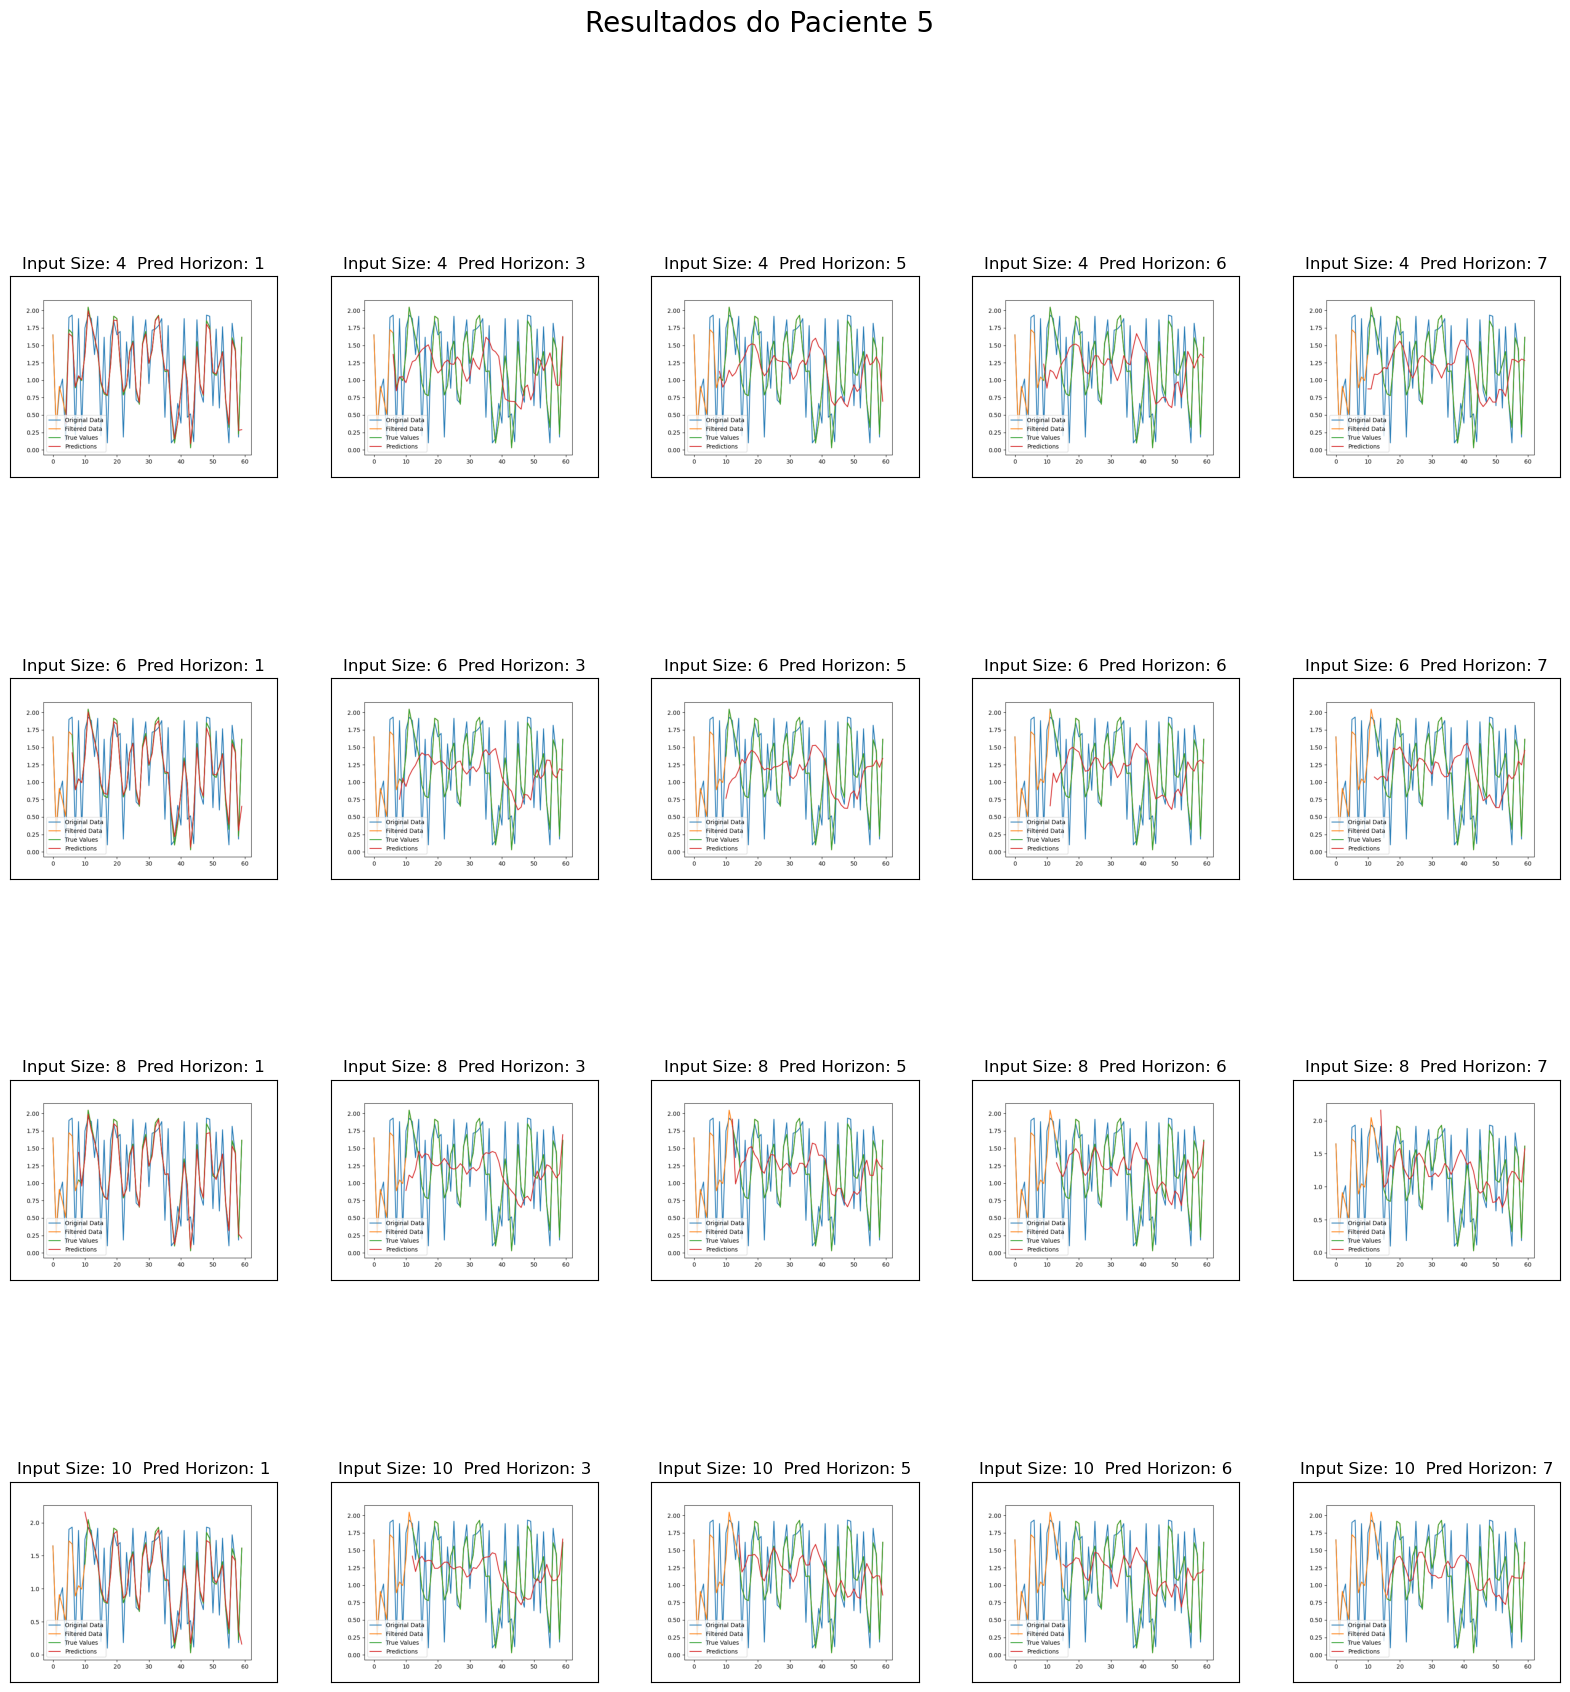

In [53]:
plot_patient_results(5)

# Modelo 6 - Transformers

In [15]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.layers import Input, Dense, LayerNormalization, MultiHeadAttention, GlobalAveragePooling1D
from darts.models.forcasting import TFTModel

def transformer_model(input_size, pred_horizon):
    n_features = 1

    # Input layer
    inputs = Input(shape=(input_size*2, n_features))

    # Crie uma instância do modelo TFT
    tft = TFTModel(num_static_features=0, 
              num_categorical_features=0,
              hidden_layer_sizes=[64, 64],
              input_sequence_length=input_size,
              output_sequence_length=pred_horizon)

    # Passe os dados de entrada através do modelo TFT
    tft_outputs = tft(inputs)

    # Output layer
    outputs = Dense(units=pred_horizon, activation='linear')(tft_outputs)

    model = Model(inputs=inputs, outputs=outputs)
    return model

# Agora você pode usar esta função para criar o modelo e treiná-lo como antes.


def train_transformer_model(data, input_size, pred_horizon):
    # Filtragem
    data_filter = filtragem(data)

    # PARÂMETROS
    optimizer = Adam()
    loss = MeanSquaredError()
    epochs = 300

    model = transformer_model(input_size, pred_horizon)
    model.compile(optimizer=optimizer, loss=loss)

    for i in range(0, np.size(data_filter, 1)):
        X, y = data_prep(data_filter[:, i], input_size, pred_horizon, True)
        X_dev = derivada(X)  # Calcular a derivada do X
        X_concat = np.concatenate((X, X_dev), axis=1)

        if i == 0:
            X_train = X_concat
            y_train = y
        else:
            X_train = np.concatenate((X_train, X_concat), axis=0)
            y_train = np.concatenate((y_train, y), axis=0)

    # X_train, y_train = [], []

    # for i in range(data_filter.shape[1]):
    #     X, y = data_prep(data_filter[:, i], input_size, pred_horizon, True)
    #     X_dev = derivada(X)
    #     X_concat = np.concatenate((X, X_dev), axis=1)

    #     X_train.append(X_concat)
    #     y_train.append(y)

    # X_train = np.concatenate(X_train, axis=0)
    # y_train = np.concatenate(y_train, axis=0)
    
    if X_train.size != 0 and y_train.size != 0:
        # Treine o modelo
        model.fit(X_train, y_train, epochs=epochs, verbose=0)

    score = model.evaluate(X_train, y_train, verbose=0)
    print('Score do modelo:', score)

    model_path = 'models_transformer/' + str(input_size) + '_' + str(pred_horizon)
    model.save(model_path)
    print("Model --> ", model_path)

    tf.keras.backend.clear_session()


: 

In [84]:
with tf.device('/cpu:0'):
    for input_size in n:
        for pred_horizon in pred_horizons:
            train_transformer_model(train_patients ,input_size, pred_horizon)

NameError: name 'TFT' is not defined

## Test

In [74]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow import keras

def evaluate_model(model, X_test, y_test):
    """
    Evaluate the model on test data and return the evaluation metrics.
    """
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    corr = np.corrcoef(y_test.squeeze(), y_pred.squeeze())[0, 1]
    return mae, mse, corr

from scipy import signal
def ccf_values(series1, series2):
    p = series1
    q = series2
    p = (p - np.mean(p)) / (np.std(p) * len(p))
    q = (q - np.mean(q)) / (np.std(q))  
    c = np.correlate(p, q, 'full')
    return c

def ccf_plot(path, i, lags, ccf):
    fig, ax =plt.subplots(figsize=(9, 6))
    ax.plot(lags, ccf)
    ax.axvline(x = 0, color = 'black', lw = 1)
    ax.axhline(y = 0, color = 'black', lw = 1)
    ax.axhline(y = np.max(ccf), color = 'blue', lw = 1, linestyle='--', label = 'highest +/- correlation')
    ax.axhline(y = np.min(ccf), color = 'blue', lw = 1, linestyle='--')
    ax.set(ylim = [-1, 1])
    ax.set_title('Cross Correlation', weight='bold', fontsize = 15)
    ax.set_ylabel('Correlation Coefficients', weight='bold', 
    fontsize = 12)
    ax.set_xlabel('Time Lags', weight='bold', fontsize = 12)
    plt.legend()
    plt.savefig(os.path.join(path, f'paciente_{i}_correlation.png'))
    plt.close()

def test_transformer_model(data, input_size, pred_horizon):
    # Load the trained model
    model_path = 'models_transformer/' + str(input_size) + '_' + str(pred_horizon)
    model = tf.keras.models.load_model(model_path)

    # Create directories to save the plots and evaluation results
    plots_path = 'plots_transformers/' + str(input_size) + '_' + str(pred_horizon)
    os.makedirs(plots_path, exist_ok=True)
    results_path = 'results_transformers/' + str(input_size) + '_' + str(pred_horizon)
    os.makedirs(results_path, exist_ok=True)

    for i in range(0, np.size(data, 1)):
        # Filter the data and prepare the test inputs and targets
        data_filter = filtragem(data[:, i])
        X_test, y_test = data_prep(data_filter, input_size, pred_horizon, True)
        X_test_dev = derivada(X_test)

        X_test_concat = np.concatenate((X_test, X_test_dev), axis=1)
        X_test_concat = X_test_concat.reshape((X_test_concat.shape[0], X_test_concat.shape[1], 1))

        # Make predictions
        y_pred = model.predict(X_test_concat)

        # Plot the data and predictions
        plt.plot(data[:, i], label='Original Data')
        plt.plot(data_filter, label='Filtered Data')
        plt.plot(np.arange(input_size+pred_horizon-1, len(data_filter)), y_test.squeeze(), label='True Values')
        plt.plot(np.arange(input_size+pred_horizon-1, len(data_filter)), y_pred.squeeze(), label='Predictions')
        plt.legend()
        plt.savefig(os.path.join(plots_path, f'paciente_{i}.png'))
        plt.close()

        # # Compute Cross-correlation
        # corr_values = signal.correlate(y_pred.squeeze(), y_test.squeeze(), mode='full')
        # corr_values = corr_values / np.concatenate((np.arange(1, len(y_pred)+1), np.arange(len(y_pred)-1, 0, -1)))
        # plt.plot(np.arange(-len(y_pred)+1, len(y_pred)), corr_values)
        # plt.xlim((-15, 15))
        # plt.savefig(os.path.join(plots_path, f'paciente_{i}_correlation.png'))
        # plt.close()

        # Evaluate the model and save the results
        mae, mse, corr = evaluate_model(model, X_test_concat, y_test)
        with open(os.path.join(results_path, f'paciente_{i}.txt'), 'w') as f:
            f.write(f'MAE: {mae:.4f}\nMSE: {mse:.4f}\nCORR: {corr:.4f}')

    tf.keras.backend.clear_session()

In [75]:
for input_size in n:
    for pred_horizon in pred_horizons:
        test_transformer_model(test_patients, input_size, pred_horizon)

2023-10-10 23:54:44.199404: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 32ms/step


2023-10-10 23:55:03.519100: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 26ms/step


KeyboardInterrupt: 

# Generative AI

In [43]:
from tensorflow.keras import layers
# Defina o tamanho do vetor de ruído de entrada para o gerador
noise_dim = 10

patients_normalize = (patients - np.min(patients)) / (np.max(patients) - np.min(patients)) * 2 - 1

def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(256, input_shape=(noise_dim,)))
    model.add(layers.ReLU())  # Usando ReLU em vez de LeakyReLU
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(512))
    model.add(layers.ReLU())  # Usando ReLU em vez de LeakyReLU
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(1024))
    model.add(layers.ReLU())  # Usando ReLU em vez de LeakyReLU
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(41, activation='tanh'))
    return model

def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(256, input_shape=(41,)))
    model.add(layers.ReLU())  # Usando ReLU em vez de LeakyReLU
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(512))
    model.add(layers.ReLU())  # Usando ReLU em vez de LeakyReLU
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(1024))
    model.add(layers.ReLU())  # Usando ReLU em vez de LeakyReLU
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(1, activation='sigmoid'))
    return model


# Defina as funções de perda
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# Defina os otimizadores
generator_optimizer = tf.keras.optimizers.Adam(0.0002)
discriminator_optimizer = tf.keras.optimizers.Adam(0.0002)

# Crie os modelos
generator = make_generator_model()
discriminator = make_discriminator_model()

# Defina um valor máximo para o peso (pode ser ajustado conforme necessário)
clip_value = 0.01

# Função de treinamento com Weight Clipping
@tf.function
def train_step(real_data):
    noise = tf.random.normal([len(real_data), noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_data = generator(noise, training=True)

        real_output = discriminator(real_data, training=True)
        fake_output = discriminator(generated_data, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # Aplicar Weight Clipping ao discriminador
    clipped_gradients = [tf.clip_by_value(grad, -clip_value, clip_value) for grad in gradients_of_discriminator]
    discriminator_optimizer.apply_gradients(zip(clipped_gradients, discriminator.trainable_variables))

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    
    return gen_loss, disc_loss

# Treinamento
num_epochs = 10000
batch_size = 64

for epoch in range(num_epochs):
    gen_loss_total = 0
    disc_loss_total = 0

    for i in range(0, len(patients), batch_size):
        batch = patients_norm[i:i+batch_size]
        gen_loss, disc_loss = train_step(batch)
        gen_loss_total += gen_loss
        disc_loss_total += disc_loss

    if epoch % 1000 == 0:
        print(f'Epoch {epoch}/{num_epochs}, Generator Loss: {gen_loss_total}, Discriminator Loss: {disc_loss_total}')

# Geração de dados sintéticos

def generate_fake_data(num_samples):
    noise = tf.random.normal([num_samples, noise_dim])
    generated_data = generator(noise, training=False)
    return generated_data.numpy()

# Gerar dados sintéticos
dados_sinteticos = generate_fake_data(60)  # Gere 60 pontos de dados sintéticos
dados_sinteticos = (dados_sinteticos + 1) / 2 * (np.max(patients) - np.min(patients)) + np.min(patients)

2023-10-11 17:26:35.417078: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x60x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x60x1x1xi1>'
loc

Epoch 0/10000, Generator Loss: 0.8539239764213562, Discriminator Loss: 1.8202539682388306
Epoch 1000/10000, Generator Loss: 0.6931471228599548, Discriminator Loss: 1.3862942457199097
Epoch 2000/10000, Generator Loss: 0.6931471228599548, Discriminator Loss: 1.3862943649291992
Epoch 3000/10000, Generator Loss: 0.6935634613037109, Discriminator Loss: 1.3873001337051392
Epoch 4000/10000, Generator Loss: 0.6931601166725159, Discriminator Loss: 1.3863191604614258


KeyboardInterrupt: 

In [44]:
dados_sinteticos.shape

(60, 41)

In [45]:
dados_sinteticos = dados_sinteticos.astype(int)

## Normalização

In [46]:
# Valor mínimo e máximo desejado
min_value = 80
max_value = 140

# Calcula o mínimo e máximo do dataset original
min_data = np.min(dados_sinteticos)
max_data = np.max(dados_sinteticos)

print(min_data, max_data)

patients_sintetic_norm = (dados_sinteticos - min_value) / (max_value - min_value)

# Imprime o dataset normalizado
print(patients_sintetic_norm.shape)

86 196
(60, 41)


## train_test_split

In [47]:
from sklearn.model_selection import train_test_split

# Dividindo os dados em conjuntos de treinamento e teste
train_data_sintetic, test_data_sintetic = train_test_split(patients_sintetic_norm.T, test_size=0.3, random_state=42)

# Transpondo novamente os dados para que as linhas correspondam aos dias da série temporal
train_data_sintetic = train_data_sintetic.T
test_data_sintetic = test_data_sintetic.T

# Separando os pacientes nos conjuntos de treinamento e teste
train_patients_sintetic = train_data_sintetic
test_patients_sintetic = test_data_sintetic

# Imprimindo o tamanho dos conjuntos de treinamento e teste
print("Tamanho dos dados de treinamento: ", train_data_sintetic.shape)
print("Tamanho dos dados de teste: ", test_data_sintetic.shape)


Tamanho dos dados de treinamento:  (60, 28)
Tamanho dos dados de teste:  (60, 13)


## Test

In [48]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow import keras

def evaluate_model(model, X_test, y_test):
    """
    Evaluate the model on test data and return the evaluation metrics.
    """
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    corr = np.corrcoef(y_test.squeeze(), y_pred.squeeze())[0, 1]
    return mae, mse, corr

from scipy import signal
def ccf_values(series1, series2):
    p = series1
    q = series2
    p = (p - np.mean(p)) / (np.std(p) * len(p))
    q = (q - np.mean(q)) / (np.std(q))  
    c = np.correlate(p, q, 'full')
    return c

def ccf_plot(path, i, lags, ccf):
    fig, ax =plt.subplots(figsize=(9, 6))
    ax.plot(lags, ccf)
    ax.axvline(x = 0, color = 'black', lw = 1)
    ax.axhline(y = 0, color = 'black', lw = 1)
    ax.axhline(y = np.max(ccf), color = 'blue', lw = 1, linestyle='--', label = 'highest +/- correlation')
    ax.axhline(y = np.min(ccf), color = 'blue', lw = 1, linestyle='--')
    ax.set(ylim = [-1, 1])
    ax.set_title('Cross Correlation', weight='bold', fontsize = 15)
    ax.set_ylabel('Correlation Coefficients', weight='bold', 
    fontsize = 12)
    ax.set_xlabel('Time Lags', weight='bold', fontsize = 12)
    plt.legend()
    plt.savefig(os.path.join(path, f'paciente_{i}_correlation.png'))
    plt.close()

def test_model_gradin_sintetic(data, input_size, pred_horizon):
    """
    Test the trained model on a group of test patients and save the evaluation metrics and plots.
    """
    # Load the trained model
    model_path = 'models_gradin/' + str(input_size) + '_' + str(pred_horizon)
    model = keras.models.load_model(model_path)

    # Create directories to save the plots and evaluation results
    plots_path = 'plots_gradin_sintetic/' + str(input_size) + '_' + str(pred_horizon)
    os.makedirs(plots_path, exist_ok=True)
    results_path = 'results_gradin_sintetic/' + str(input_size) + '_' + str(pred_horizon)
    os.makedirs(results_path, exist_ok=True)

    for i in range(0, np.size(data, 1)):
        # Filter the data and prepare the test inputs and targets
        data_filter = filtragem(data[:, i])
        X_test, y_test = data_prep(data_filter, input_size, pred_horizon, True)
        X_test_dev = derivada(X_test)

        X_test_concat = np.concatenate((X_test, X_test_dev), axis=1)
        X_test_concat = X_test_concat.reshape((X_test_concat.shape[0], X_test_concat.shape[1], 1))

        # Make predictions
        y_pred = model.predict(X_test_concat)

        # Plot the data and predictions
        plt.plot(data[:, i], label='Original Data')
        plt.plot(data_filter, label='Filtered Data')
        plt.plot(np.arange(input_size+pred_horizon-1, len(data_filter)), y_test.squeeze(), label='True Values')
        plt.plot(np.arange(input_size+pred_horizon-1, len(data_filter)), y_pred.squeeze(), label='Predictions')
        plt.legend()
        plt.savefig(os.path.join(plots_path, f'paciente_{i}.png'))
        plt.close()

        # Compute Cross-correlation
        # corr_values = signal.correlate(y_pred.squeeze(), y_test.squeeze(), mode='full')
        # corr_values = corr_values / np.concatenate((np.arange(1, len(y_pred)+1), np.arange(len(y_pred)-1, 0, -1)))
        # #print(corr_values)
        # plt.plot(np.arange(-len(y_pred)+1, len(y_pred)), corr_values)
        # plt.xlim((-15, 15))
        # plt.show()

        # # Compute cross-correlation
        # x = data_filter[input_size-1:-pred_horizon]
        # y = y_pred.squeeze()
        # ccf_ielts = ccf_values(x, y)
        # lags = signal.correlation_lags(len(x), len(y))
        # ccf_plot(plots_path, i, lags, ccf_ielts)
        
        
        # Evaluate the model and save the results
        mae, mse, corr = evaluate_model(model, X_test_concat, y_test)
        with open(os.path.join(results_path, f'paciente_{i}.txt'), 'w') as f:
            f.write(f'MAE: {mae:.4f}\nMSE: {mse:.4f}\nCORR: {corr:.4f}')

    backend.clear_session()


In [49]:
for input_size in n:
    for pred_horizon in [1, 3, 5, 6, 7]:
        test_model_gradin_sintetic(test_patients_sintetic ,input_size, pred_horizon)

2023-10-12 01:39:34.253956: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 5ms/step


2023-10-12 01:39:41.421642: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 5ms/step


2023-10-12 01:39:45.728394: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 5ms/step


2023-10-12 01:39:49.887195: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 5ms/step


2023-10-12 01:39:54.067195: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 5ms/step


2023-10-12 01:39:58.533093: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 5ms/step


2023-10-12 01:40:02.896318: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 5ms/step


2023-10-12 01:40:07.261641: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 5ms/step


2023-10-12 01:40:11.573387: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 4ms/step


2023-10-12 01:40:15.534386: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 4ms/step


2023-10-12 01:40:19.354933: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 4ms/step


2023-10-12 01:40:23.158486: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 4ms/step


2023-10-12 01:40:27.582933: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 5ms/step


2023-10-12 01:40:31.629289: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 4ms/step


2023-10-12 01:40:35.695878: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 4ms/step


2023-10-12 01:40:39.724770: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 4ms/step


2023-10-12 01:40:43.828506: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 5ms/step


2023-10-12 01:40:48.138225: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 8ms/step


2023-10-12 01:40:52.444036: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 4ms/step


2023-10-12 01:40:56.373735: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 4ms/step


### AVG

In [50]:
import os

for horizon in pred_horizons:
    for input_size in n:
        results_dir = f"results_gradin_sintetic/{input_size}_{horizon}"

        # Criar dicionário para armazenar os resultados
        results_dict = {}

        # Percorrer todos os arquivos txt na pasta de resultados
        for file_name in os.listdir(results_dir):
            if file_name.endswith(".txt"):
                # Obter o nome do paciente a partir do nome do arquivo
                patient_name = file_name.split("_")[0]
                file_path = os.path.join(results_dir, file_name)
                with open(file_path, "r") as f:
                    # Ler os resultados do arquivo
                    results = [float(line.split(":")[1].strip()) for line in f.readlines()]
                # Adicionar os resultados ao dicionário
                if patient_name in results_dict:
                    results_dict[patient_name].append(results)
                else:
                    results_dict[patient_name] = [results]

        # Calcular a média dos resultados para cada paciente
        for patient_name, results_list in results_dict.items():
            # Calcular a média de cada métrica
            mae_list = [results[0] for results in results_list]
            mae_avg = sum(mae_list) / len(mae_list)
            mse_list = [results[1] for results in results_list]
            mse_avg = sum(mse_list) / len(mse_list)
            corr_list = [results[2] for results in results_list]
            corr_avg = sum(corr_list) / len(corr_list)
            # Salvar os resultados médios em um novo arquivo txt
            output_file_path = f"results_gradin_sintetic/{input_size}_{horizon}/{patient_name}_avg.txt"
            with open(output_file_path, "w") as f:
                f.write(f"MAE: {mae_avg:.4f}\n")
                f.write(f"MSE: {mse_avg:.4f}\n")
                f.write(f"CORR: {corr_avg:.4f}\n")


In [51]:
import os
import csv

def generate_model_info_csv():
    result_path = 'results_gradin_sintetic'
    output_csv_path = 'model_info_gradin_sintetic.csv'

    # Get the list of folders in the results directory
    folders = os.listdir(result_path)

    # Initialize the data lists
    model_info = []

    # Iterate over the folders
    for folder in folders:
        folder_path = os.path.join(result_path, folder)
        if os.path.isdir(folder_path):
            # Extract input size and prediction horizon from the folder name
            input_size, pred_horizon = map(int, folder.split('_'))

            # Read the paciente_avg.txt file
            file_path = os.path.join(folder_path, 'paciente_avg.txt')
            with open(file_path, 'r') as f:
                lines = f.readlines()

            # Parse the metrics from the file
            mae = float(lines[0].split(':')[1].strip())
            mse = float(lines[1].split(':')[1].strip())
            corr = float(lines[2].split(':')[1].strip())

            # Append the data to the list
            model_info.append((input_size, pred_horizon, mae, mse, corr))

    # Sort the model info list by input_size and pred_horizon
    sorted_model_info = sorted(model_info, key=lambda x: (x[0], x[1]))

    # Write the data to a CSV file
    with open(output_csv_path, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(['Input Size', 'Prediction Horizon', 'MAE', 'MSE', 'CORR'])
        writer.writerows(sorted_model_info)

    print(f"Model information has been saved to '{output_csv_path}'.")

generate_model_info_csv()

Model information has been saved to 'model_info_gradin_sintetic.csv'.
